# FUNCTIONS CLASS DEFINITIONS

In [ ]:
! pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [200]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import warnings 
warnings.filterwarnings('ignore')

'''
Import pytorch lybraries
'''
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

''' 
Import modules for PRC and AUROC
ROC Curve AUC
PRC Curve
'''
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
import seaborn as sns

from tqdm.notebook import tqdm_notebook
import math
import gc

# Define Device
__TEST_DEVICE__ = 'gpu'

class LoadInformation():
    def __init__(self):
        self.impression =  pd.read_json('./impression_v3.json')
        '''
        Set date time as index
        '''
        self.impression.set_index('impression_time', inplace = True)
        self.impression.index.names = ['Date']
        

    '''
        Function to return a section of the data based on date and time
        data : dataset
        start: starting time
        end: ending time
    '''
    def SplitData(self, data, start, end):
        if end == '':
            return data.loc[start::, :]
        return data.loc[start:end, :]


    def  createNewData(self, window = 10):
        '''
            Extract information required
            combine ‘target_news_onehot’ after ‘click_seq_10_onehot’
        '''
        impressionMerged = []

        for (target_news_onehot, click_seq_10_onehot) in self.impression[['target_news_onehot', 'click_seq_10_onehot']].values:
            if window <= len(click_seq_10_onehot):
                init = len(click_seq_10_onehot)  - window
                end = len(click_seq_10_onehot) 
                get_click_seq_10_onehot = click_seq_10_onehot[init : end]
                get_click_seq_10_onehot.append(target_news_onehot)
                get_click_seq_10_onehot = np.array(get_click_seq_10_onehot)
                
                impressionMerged.append(get_click_seq_10_onehot)
            else:
                break


        ''' 
            insert the combination into the original dataframe
        '''
        self.impression["click_seq_10_onehot_combined"] = impressionMerged

        ''' 
            Create a new variable to extract the combined data and y
        '''
        impression = self.impression.loc[:, self.impression.columns.isin(['click_seq_10_onehot_combined', 'y'])]   

        ''' 
            Split Data into Train, Validate, Test
        '''
        impression_train = self.SplitData(impression, '2022/08/01', '2022/08/07')
        impression_validate = self.SplitData(impression, '2022/08/08', '2022/08/09')
        impression_test = self.SplitData(impression, '2022/08/10 ', '')

        return impression_train, impression_validate, impression_test

    
  
def getDevice(device):
  if device != 'cpu':
    is_cuda =  torch.cuda.is_available()
    if is_cuda:
      return torch.device('cuda')
    return torch.device('cpu')
  return torch.device('cpu')

''' 
--------------------------------------------------    MODELS   -------------------------------------------------------------- 
    Define class with the model LSTM to be used
'''

class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size = 2, num_layers = 1, dropout = 0, output_size = 1, device = 'gpu'):
        super(LSTM_Model, self).__init__()

        self.device = getDevice(device)
        self.hidden_size = hidden_size
        self.num_layer = num_layers
        
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout =  dropout,
            bidirectional = True
        )

        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.out = nn.Sigmoid()

        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):

        h0 = Variable(torch.zeros(2 * self.num_layer, x.size(0), self.hidden_size)).to(self.device) 
        c0 = Variable(torch.zeros(2 * self.num_layer, x.size(0), self.hidden_size)).to(self.device) 
        out , (hn, cn) = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :]) 
        out = self.out(out)
        return out

'''  
    Define class with the model GRU to be used
'''

class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size = 2, num_layers = 1, dropout = 0, output_size = 1, device = 'gpu'):
        super(GRU_Model, self).__init__()

        self.device = getDevice(device)
        self.hidden_size = hidden_size
        self.num_layer = num_layers
        
        self.gru = nn.GRU(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout =  dropout,
            bidirectional = True
        )

        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.out = nn.Sigmoid()
        nn.init.xavier_normal_(self.fc.weight)

    def forward(self, x):

        h0 = Variable(torch.zeros(2 * self.num_layer, x.size(0), self.hidden_size)).to(self.device) 
        
        out, hn = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        out = self.out(out)
        return out


'''  
    Define class with the model LSTM to be used
'''
class Transformer_Model(nn.Module):
    def __init__(self, d_model, nhead, device = __TEST_DEVICE__):
        
        super(Transformer_Model, self).__init__()

        self.device = getDevice(device)    
        self.encoder = nn.TransformerEncoderLayer(
            d_model  = d_model,
            nhead = nhead,
            dropout = 0.2,
            activation = 'gelu',
            batch_first = True
        )
       
        self.encoder1 = nn.TransformerEncoderLayer(
            d_model  = d_model,
            nhead = nhead,
            dropout = 0.2,
            activation = 'gelu',
            batch_first = True
        )
     
        self.encoder2 = nn.TransformerEncoderLayer(
            d_model  = d_model,
            nhead = nhead,
            dropout = 0.5,
            activation = 'gelu',
            batch_first = True
        )

        self.fc = nn.Linear(d_model, 1)
        self.out = nn.Sigmoid()

        nn.init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        out = self.encoder(x)
        out = self.encoder1(x)
        out = self.encoder2(x)
        out = self.fc(out[:, -1, :]) 
        out = self.out(out)
        return out

class FocalLoss(nn.Module):
    def __init__(self, alpha = 0.25,  gamma = 2, device = __TEST_DEVICE__ ):
        super(FocalLoss, self).__init__()

        self.device = getDevice(device)
        self.gamma = gamma
        self.alpha = torch.tensor([alpha, 1-alpha]).to(self.device)
     
            
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1)).to(self.device)
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()



class CBLoss(nn.Module):
    def __init__(
        self, 
        samples_per_class, 
        n_classes = 1, 
        beta = 0.9999,  
        gamma = 2, 
        device = __TEST_DEVICE__ 
        ):
      super(CBLoss, self).__init__()

      self.device = getDevice(device)
      self.gamma = gamma

      effective_num = 1.0 - np.power(beta, samples_per_class)
      weights = (1.0 - beta) / np.array(effective_num)
      weights = weights / np.sum(weights) * n_classes
      self.alpha = torch.tensor([weights[0].item(), weights[1].item()]).to(self.device)
    
        
    def forward(self, inputs, targets):
      BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
      targets = targets.type(torch.long)
      at = self.alpha.gather(0, targets.data.view(-1)).to(self.device)
      pt = torch.exp(-BCE_loss)
      
      torch.cuda.empty_cache()

      F_loss = at*(1-pt)**self.gamma * BCE_loss
      return F_loss.mean()



class AIModel():
    def __init__(self, 
                 train, 
                 validate, 
                 test, 
                 epoch = 2, 
                 batch_size = 1, 
                 hidden_size = 2, 
                 layer_size = 1, 
                 dropout = 0, 
                 learning_rate= 1e-3, 
                 device = 'gpu', 
                 model = 'lstm', 
                 nhead = 3, 
                 typeMetric = 'f1',
                 earlyStopFlag = False,
                 lossFunction = "BCE"
                 ):
      
        self.epoch = epoch
        self.batch_size = batch_size #int(len(train)/ batch_size) #
        self.deviceName = device
        self.device = getDevice(device)
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.dropout = dropout
        self.nhead = nhead
        self.typeMetric = typeMetric
        self.earlyStopFlag = earlyStopFlag
        
  
        train_X, train_y = self.splitXY(train)
        validate_X, validate_y = self.splitXY(validate)
        test_X, test_y = self.splitXY(test)

        samplesPerClass = [(train_y == 0).sum().item(), (train_y == 1).sum().item()]


        ''' Define fezture size'''
        self.feature_size = train_X.shape[2]
     

        trainData = self.DatasetClass(train_X, train_y)
        validateData = self.DatasetClass(validate_X, validate_y)
        testData = self.DatasetClass(test_X, test_y)
        
        self.train = DataLoader(dataset = trainData, batch_size = self.batch_size, shuffle = True)
        self.validate = DataLoader(dataset = validateData, batch_size = len(validateData), shuffle = False)
        self.test = DataLoader(dataset=testData, batch_size = len(testData), shuffle = False)
        

        self.model = self.defineModel(model = model)

        if lossFunction == "BCE": self.lossFunction = nn.BCELoss()   
        elif lossFunction == 'FL': self.lossFunction = FocalLoss()  
        elif lossFunction == "CB": self.lossFunction = CBLoss(samples_per_class = samplesPerClass)#FocalLoss(alpha = 0.09559198  )
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)

    
    def splitXY(self, data):
        X = []
        for i in data["click_seq_10_onehot_combined"]:
            X.append(i)
        y = data["y"]
        return np.asarray(X), np.asarray(y).reshape(len(y), 1)

    class DatasetClass(Dataset):
        def __init__(self, inputs, labels):
            self.inputs, self.labels = self.toTensor(inputs, labels)
            self.n_samples, self.step, self.features = inputs.shape

        def toTensor(self, inputs, labels):
            return torch.from_numpy(inputs).to(torch.float32), torch.from_numpy(labels).to(torch.float32)

        def __getitem__(self, index):
            return self.inputs[index], self.labels[index]

        def __len__(self):
            return self.n_samples

    def defineModel(self,  model = 'lstm'):
        if model == 'lstm':
            return LSTM_Model(input_size = self.feature_size, hidden_size = self.hidden_size, num_layers = self.layer_size, dropout= self.dropout, device = self.deviceName ).to(self.device)
        elif model == 'gru':
            return GRU_Model(input_size = self.feature_size, hidden_size = self.hidden_size, num_layers = self.layer_size, dropout= self.dropout, device = self.deviceName ).to(self.device) 
        elif model == 'transformer':
            return Transformer_Model(self.feature_size, nhead = self.nhead, device = self.deviceName ).to(self.device) 

    def trainModel(self, show_process = True, process_factor = 10, patiente = 2):

        process =  tqdm_notebook(range(self.epoch))

        self.lossTraining = []
        self.lossValidation = []
     
        patiente_acum = 0  # patiente counter

        prev_Fscore = -1e2  # best loss from validation
        best_Model =  copy.deepcopy(self.model.state_dict()) # best model
        self.best_epoch = 0

       

        for epoch in process:
            ''' 
                ----------------------------------  TRAINING STAGE  ---------------------------------------
                
            '''
            loss_train = 0.0
            loss_validate = 0.0

            outputAcum = []
            groundTruthAcum = []
            flag = True

            metricTraining = 0
            metricValidation =0
            
            self.model.train()
            
            
            
            for index, (inputs, labels) in enumerate(self.train):
                
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                '''
                    ---------------   Forward    --------------------
                '''
                outputs = self.model(inputs)
                loss = self.lossFunction(outputs, labels)

                '''
                    ---------------   Backward    --------------------
                '''
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                '''
                    ---------------  Get predicted to calculate accuracy ----------------
                '''
                predicted = outputs.cpu().detach().numpy()
                # predicted[predicted >= 0.5] = 1
                # predicted[predicted < 0.5] = 0

                ground_truth = labels.cpu().detach().numpy()


                if flag:
                  outputAcum = predicted
                  groundTruthAcum = ground_truth
                  flag = False

                outputAcum = np.append(outputAcum, predicted)
                groundTruthAcum = np.append(groundTruthAcum, ground_truth)

                f_score = self.metrics(groundTruthAcum, outputAcum, typeMetric = self.typeMetric)

                
                
                if show_process:
                    if (index + 1) % process_factor== 0:
                        text = f'Training Stage ==> Epoch: {epoch} / {self.epoch - 1} | Step: {index} / {len(self.train)} | Training loss: {loss_train:.5f} |  Training {self.typeMetric}: {f_score:.5f}'
                        print(text)
                        
                
                loss_train = loss.item()
                metricTraining = f_score

                
            self.lossTraining.append(loss_train)
          
           
            
            ''' 
                ----------------------------------  EVALUATION STAGE  ---------------------------------------
                
            '''
            del inputs, labels, index, outputs, predicted, ground_truth
            
            # Set variables for calculating metrics
            outputAcum = []
            groundTruthAcum = []
            flag = True

            self.model.eval()
            with torch.no_grad():
                for index, (inputs, labels) in enumerate(self.validate):
                    
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
              
                    outputs = self.model(inputs)
                    loss = self.lossFunction(outputs, labels)

                    '''
                        ---------------  Get predicted to calculate accuracy ----------------
                    '''
                    predicted = outputs.cpu().detach().numpy()
                    # predicted[predicted >= 0.5] = 1
                    # predicted[predicted < 0.5] = 0

                    ground_truth = labels.cpu().detach().numpy()

                  
                    
                
                    loss_validate = loss.item()
                    


                    if flag:
                      outputAcum = predicted
                      groundTruthAcum = ground_truth
                      flag = False

                    outputAcum = np.append(outputAcum, predicted)
                    groundTruthAcum = np.append(groundTruthAcum, ground_truth)


                self.lossValidation.append(loss_validate)
              

                f_score = self.metrics(groundTruthAcum, outputAcum, typeMetric = self.typeMetric)
                metricValidation = f_score


                if show_process:
                  text = f'Validation Stage ==> Epoch: {epoch} / {self.epoch - 1} | Validation loss: {loss_validate:.5f} |  Validation {self.typeMetric}: {f_score:.5f}'
                  print(text)

                '''
                    Early stop base on patiente
                '''
         
                if ~math.isnan(f_score) or f_score == 0:
                  if f_score > prev_Fscore:
                    prev_Fscore = f_score
                    best_Model =  copy.deepcopy(self.model.state_dict())
                    self.best_epoch = epoch
                    patiente_acum = 0
                  else:
                    patiente_acum += 1
                else:
                  patiente_acum += 1


                if self.earlyStopFlag and patiente_acum > patiente:
                  # Load best model in current model
                  self.model.load_state_dict(best_Model)
                  print(f'Early Stop Load Model from best epoch {self.best_epoch}')
                  break



            process.set_postfix({'Epoch':epoch,
            'training_loss': loss_train, 
            f'training {self.typeMetric}': metricTraining, 
            'validate_loss': loss_validate, 
            f'Validation {self.typeMetric}': metricValidation, 
            'patiente': patiente_acum}
            )
                   
            del inputs, labels, index, outputs, predicted, ground_truth 

        if ~self.earlyStopFlag:
          # Load best model in current model
          self.model.load_state_dict(best_Model)
          print(f'Load Model from best epoch {self.best_epoch}')  


    '''
       Metrics         
    '''
    def metrics(self, y, y_hat, typeMetric = 'f1' ):

      precision, recall, thresholds = precision_recall_curve(y, y_hat)
      
      if typeMetric == 'f1':
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        return  fscore[ix]
      elif typeMetric == 'recall':
        ix = np.argmax(recall)
        return recall[ix]
      elif typeMetric == 'precision':
        ix = np.argmax(precision)
        return precision[ix]
      elif typeMetric == 'AUROC':
        return roc_auc_score(y, y_hat)
      elif typeMetric == 'PRC':
        return auc(recall, precision)

  
    '''
       Test Models         
    '''

    # apply threshold to positive probabilities to create labels
    def to_labels(self, pos_probs, threshold):
      return (pos_probs >= threshold).astype('int')
     
    def testModel_GetThreshold(self, data, typeData = 'f1'):
        torch.cuda.empty_cache()

        outputAcum = []
        groundTruthAcum = []
        loss_acum = []
        flag = True

        self.model.eval()
        with torch.no_grad():
            for index, (inputs, labels) in enumerate(data):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.lossFunction(outputs, labels)

                predicted = outputs.cpu().detach().numpy()
                ground_truth = labels.cpu().detach().numpy()

                if flag:
                  outputAcum = predicted
                  groundTruthAcum = ground_truth
                  flag = False

                outputAcum = np.append(outputAcum, predicted)
                groundTruthAcum = np.append(groundTruthAcum, ground_truth)
                loss_acum.append(loss.item())

        thresholds = np.arange(0, 1, 0.001)

        if typeData == 'f1':
          scores = [f1_score(groundTruthAcum, self.to_labels(outputAcum, t)) for t in thresholds]
          ix = np.argmax(scores)
          return thresholds[ix], scores[ix]
        elif typeData == 'AUROC':
          scores = [roc_auc_score(groundTruthAcum, self.to_labels(outputAcum, t)) for t in thresholds]
          ix = np.argmax(scores)
          return thresholds[ix], scores[ix]
        elif typeData == 'recall':
          scores = [recall_score(groundTruthAcum, self.to_labels(outputAcum, t)) for t in thresholds]
          ix = np.argmax(scores)
          return thresholds[ix], scores[ix]
        elif typeData == 'PRC':
          scores = []
          for t in thresholds:
            precision, recall, _ = precision_recall_curve(groundTruthAcum, self.to_labels(outputAcum, t))
            scores.append(auc(recall, precision))
          scores = np.array(scores)
          ix = np.argmax(scores)
         
          return thresholds[ix], scores[ix]
                

    def testModel(self, data, showMetrics = False, threshold = 0.5, threshold_flag = False):
        torch.cuda.empty_cache()

        outputAcum = []
        groundTruthAcum = []
        loss_acum = []
        flag = True

        self.model.eval()
        with torch.no_grad():
            for index, (inputs, labels) in enumerate(data):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.lossFunction(outputs, labels)

                predicted = outputs.cpu().detach().numpy()
                
                if threshold_flag:
                  predicted[predicted >= threshold] = 1
                  predicted[predicted < threshold] = 0

                ground_truth = labels.cpu().detach().numpy()

                if flag:
                  outputAcum = predicted
                  groundTruthAcum = ground_truth
                  flag = False

                outputAcum = np.append(outputAcum, predicted)
                groundTruthAcum = np.append(groundTruthAcum, ground_truth)
                loss_acum.append(loss.item())

        if showMetrics:
       
          loss = np.array(loss_acum).sum().item() / len(loss_acum)
          metrics = self.metrics( groundTruthAcum, outputAcum, typeMetric = self.typeMetric)
          precision = precision_score( groundTruthAcum, outputAcum)
          f1 = f1_score( groundTruthAcum, outputAcum)
          recall = recall_score(groundTruthAcum, outputAcum)
          AUC = roc_auc_score(groundTruthAcum, outputAcum)
          classificationReport = classification_report(groundTruthAcum, outputAcum)

          text = f'Model Metrics: | Loss: {loss} |  {self.typeMetric}: {metrics} | precision: {precision} |'
          text += f'recall: {recall} | f1_score: {f1} | AUROC: {AUC}'
          print(text)

          print('Confusion Matrix')
          tn, fp, fn, tp = confusion_matrix(groundTruthAcum, outputAcum).ravel()
          print(tn, fp, fn, tp)

          print("Classification Report")
          print(classificationReport)


        else:
          return {
            'y_hat' : outputAcum,
            'y': groundTruthAcum
          }
      

    '''
      Functions to calculate the AUROC
    '''
    def ROC_plot(self, data, thresholdCompare = 0.5, G_mean_flag = False):
      G_mean = None
      G_mean_index = None

      torch.cuda.empty_cache()
      modelResults = self.testModel(data, threshold = thresholdCompare)
      auroc = roc_auc_score(modelResults['y'], modelResults['y_hat'])
      fpr, tpr, _ = roc_curve(modelResults['y'], modelResults['y_hat'])

      if G_mean_flag:
        G_mean = np.sqrt(tpr * (1 - fpr))
        G_mean_index = np.argmax(G_mean)
        print(f"G-mean = {G_mean[G_mean_index]}")

      fig, ax = plt.subplots()
      ax.plot(fpr, tpr, label= f'AUROC : {auroc:.4f}', marker = '.')
      ax.fill_between(fpr, tpr, alpha=.4)
      if G_mean_flag:
        ax.scatter(fpr[G_mean_index], tpr[G_mean_index],  marker='o', color='red', label=f'G-mean : {G_mean[G_mean_index]:.4f}')

      ax.plot([0, 1],[0, 1], '-.')
      ax.set_xlim([-0.01, 1.05])
      ax.set_ylim([-0.01, 1.05])
      ax.set(title = 'Receiver operating characteristic (ROC)', xlabel ='False Positive Rate', ylabel='True Positive Rate')
      ax.legend(loc='lower right')
      plt.show()

      if G_mean_flag:
        return G_mean[G_mean_index]


    def ROC_curves(self, showTestFlag = False):
        torch.cuda.empty_cache()

        train = self.testModel(self.train)
        aurocTrain = roc_auc_score(train['y'], train['y_hat'])
        fprTrain, tprTrain, _ = roc_curve(train['y'], train['y_hat'])

        G_mean_Training = np.sqrt(tprTrain * (1 - fprTrain))
        G_mean_index = np.argmax(G_mean_Training)
        g_mean = G_mean_Training[G_mean_index]
       
        # print(f"G-mean = {g_mean}")

        validate = self.testModel(self.validate)
        aurocValidate = roc_auc_score(validate['y'], validate['y_hat'])
        fprValidate, tprValidate, _ = roc_curve(validate['y'], validate['y_hat'])

        fprTest , tprTest = None, None
        if showTestFlag:
          test = self.testModel(self.test)
          aurocTest = roc_auc_score(test['y'], test['y_hat'])
          fprTest, tprTest, _ = roc_curve(test['y'], test['y_hat'])

        
        fig, ax = plt.subplots()
        ax.plot(fprTrain, tprTrain, label= f'Train Dataset : {aurocTrain:.4f}', marker = '.')
        ax.fill_between(fprTrain, tprTrain, alpha=.4)
        ax.plot(fprValidate, tprValidate, label= f'Validate Dataset : {aurocValidate:.4f}', marker = '.')
        # ax.scatter(fprTrain[G_mean_index], tprTrain[G_mean_index],  marker='o', color='red', label=f'G-mean : {g_mean:.4f}')
        if showTestFlag:  ax.plot(fprTest, tprTest, label= f'Test Dataset : {aurocTest:.4f}', marker = '.') 
        ax.plot([0, 1],[0, 1], '-.')
        ax.set_xlim([-0.01, 1.05])
        ax.set_ylim([-0.01, 1.05])
        ax.set(title = 'Receiver operating characteristic (ROC)', xlabel ='False Positive Rate', ylabel='True Positive Rate')
        ax.legend(loc='lower right')
          
        plt.show()
        gc.collect()
      

    '''
      function to calculate the PRC for all datasets
    '''

    def PRC_plot(self, data, thresholdCompare = 0.5, F_score_flag = False):
      torch.cuda.empty_cache()

      fscore = None
      index = None

      modelResults = self.testModel(data, threshold = thresholdCompare)
      presicion, recall, _  = precision_recall_curve(modelResults['y'], modelResults['y_hat'])
      AUC = auc(recall, presicion)

    

      if F_score_flag:
        f1 = (2 * presicion * recall) / (presicion + recall)
        ix = np.argmax(f1)
        f1 = f1[ix]
        print(f"f1-score = {f1}")

      fig1, ax =plt.subplots()
      ax.plot(recall, presicion, label=f'Test Dataset: {AUC:.4f}', marker = '.')
      ax.fill_between(recall, presicion, alpha=0.4)

      if F_score_flag: ax.scatter(recall[index], presicion[index], marker='o', color='red', label=f'f1-score : {f1:.4f}')
      ax.set_xlim([-0.01, 1.05])
      ax.set_ylim([-0.01, 1.05])
      ax.set(title = 'Precision - Recall Curve', xlabel ='Recall', ylabel='Precision')
      ax.legend(loc='upper right') 
      plt.show()
      gc.collect()

      if F_score_flag:
        return fscore[index]

    def PRC_curves(self, showTestFlag = False):
        torch.cuda.empty_cache() 
        # Train Dataset
        train = self.testModel(self.train)
        presicionTrain, recallTrain, _  = precision_recall_curve(train['y'], train['y_hat'])
        auc_Train = auc(recallTrain, presicionTrain)


        f1_Train = (2 * presicionTrain * recallTrain) / (presicionTrain + recallTrain)
        ix_Train = np.argmax(f1_Train)
        f1_Train = f1_Train[ix_Train]

        f2_Train = ((1 - (0.5)**2 ) * presicionTrain * recallTrain) / ((0.5)**2 * presicionTrain + recallTrain)
        ix_2Train = np.argmax(f2_Train)
        f2_Train = f2_Train[ix_2Train]

        # print(f'f1-score = {f1_Train}')

        # Validation Dataset
        validate = self.testModel(self.validate)
        presicionValidate, recallValidate, _ = precision_recall_curve(validate['y'], validate['y_hat'])
        auc_Validate = auc(recallValidate, presicionValidate)

        f1_Validate = (2 * presicionValidate * recallValidate) / (presicionValidate + recallValidate)
        ix_Validate = np.argmax(f1_Validate)
        f1_Validate = f1_Validate[ix_Validate]

        # Testing Dataset
        presicionTest, recallTest = None, None
        if showTestFlag:
          test = self.testModel(self.test)
          presicionTest, recallTest, _ = precision_recall_curve(test['y'], test['y_hat'])
          f1_Test, auc_Test = f1_score(test['y'], test['y_hat']), auc(recallTest, presicionTest)
        # Plot
        fig1, ax =plt.subplots()
        ax.plot(recallTrain, presicionTrain, label=f'Train Dataset: {auc_Train:.4f}', marker = '.')
        ax.fill_between(recallTrain, presicionTrain, alpha=0.4)
        ax.plot(recallValidate, presicionValidate, label=f'Validate Dataset: {auc_Validate:.4f}' , marker = '.' )
        if showTestFlag: ax.plot(recallTest, presicionTest, label=f'Test Dataset: {auc_Test:.4f}', marker = '.') 
        # ax.scatter(recallTrain[ix_Train], presicionTrain[ix_Train], marker='o', color='red', label=f'f1-score : {f1_Train:.4f}')
        # ax.scatter(recallTrain[ix_2Train], presicionTrain[ix_2Train], marker='o', color='red', label=f'f0.5-score : {f2_Train:.4f}')
        ax.set_xlim([-0.01, 1.05])
        ax.set_ylim([-0.01, 1.05])
        ax.set(title = 'Precision - Recall Curve', xlabel ='Recall', ylabel='Precision')
        ax.legend(loc='upper left') 
        plt.show()

        gc.collect()
  
        
    ''' 
      Confusion Matrix Functions
    '''
    def ConfusionMatrixPlotIndividual(self, data, threshold = 0.5, threshold_flag = True):
        torch.cuda.empty_cache() 
        cfm = self.testModel(data, threshold = threshold, threshold_flag = threshold_flag)
        self.plot_ConfusionMatrix(cfm['y'], cfm['y_hat'], "Test")
        del cfm
        gc.collect()

    def ConfusionMatrixPlot(self, showTest =  False):
        torch.cuda.empty_cache() 
        train = self.testModel(self.train)
        self.plot_ConfusionMatrix(train['y'], train['y_hat'], "Train")
        validate = self.testModel(self.validate)
        self.plot_ConfusionMatrix(validate['y'], validate['y_hat'], "Validate")

        test = None
        if showTest:
          test = self.testModel(self.test)
          self.plot_ConfusionMatrix(test['y'], test['y_hat'], "Test")
        
        del train, test, validate
        gc.collect()

    def plot_ConfusionMatrix(self, groundTruth, predicted, title):
        labels = [0, 1]
        confusionMatrix = confusion_matrix(groundTruth, predicted, labels = labels)
        fig, ax = plt.subplots()
        sns.heatmap(
            confusionMatrix, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=False, 
            cmap='Blues',
            xticklabels=labels, 
            yticklabels=labels)
        ax.set(title = f'Confusion Matrix {title} ', xlabel ='Predicted', ylabel='Ground Truth')
        plt.show()

    
    '''
     Plot Accuracy and Loss curves  
    '''   
    def plot_Acc_loss(self):
        fig, ax = plt.subplots()
        ax.plot(self.lossTraining, label = f'Training', color ='b')
        ax.plot(self.lossValidation, label = f'Validation', color = 'orange')
        ax.set(xlabel = "Epoch", ylabel = "Loss")
        ax.legend(loc = 'upper right')


def plot_bar(data):
  height = [(data['y'] == 0).sum(), (data['y'] == 1).sum()]
  bars = ['0', '1']
  x_pos = np.arange(len(bars))
  plt.bar(x_pos, height, color=(0.2, 0.4, 0.6, 0.6))
  plt.xticks(x_pos, bars)
  plt.show()


def verifyDataset(data, returnEnable = False):
  zero = (data['y'] == 0).sum()
  ones = (data['y'] == 1).sum()
  print( f'positives = {ones}, negatives: {zero}   ration: {1}/{round(zero/ones)}')
  if returnEnable == True: return zero, ones


'''
  Function for undersampling the dataset 
'''
def undersamplingData(impression_train, ratio = 1/10, window = 10):
  impression_train_undersampling = pd.DataFrame.copy(impression_train)
  del impression_train

  print("DISTRIBUTION BEFORE UNDERSAMPLING")
  plot_bar(impression_train_undersampling)
      
  data = []
  pbar = tqdm_notebook(total=len(impression_train_undersampling['click_seq_10_onehot_combined']))
  pbar.set_description("Extracting Data from click seq one hot combined ")
  for i in impression_train_undersampling['click_seq_10_onehot_combined']:
    data_i = np.asarray(i)
    data.append(data_i)
    pbar.update(1)

  pbar.close()

  ''' 
  Converting data
  ''' 
  data = np.asarray(data)
  data = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))

  pbar = tqdm_notebook(total = data.shape[1])
  pbar.set_description("Creating Pandas with 10 last click as one row")
  for i in range(data.shape[1]):
    impression_train_undersampling[f'{i}_data'] = data[:, i]
    pbar.update(1)
  pbar.close()

  impression_train_undersampling.drop(labels = 'click_seq_10_onehot_combined', axis=1, inplace = True)

  # from imblearn.under_sampling import RandomUnderSampler 
  # undersampler = RandomUnderSampler(sampling_strategy= ratio , random_state=None, replacement=False)
  # X_res, y_res = undersampler.fit_resample(impression_train_undersampling.loc[:, ~impression_train_undersampling.columns.isin(['y'])], impression_train_undersampling['y'])
  # X_res['y'] = y_res

  from imblearn.under_sampling import  NearMiss 
  undersampler = NearMiss(sampling_strategy =  ratio, version=1, n_neighbors=10)
  X_res, y_res = undersampler.fit_resample(impression_train_undersampling.loc[:, ~impression_train_undersampling.columns.isin(['y'])], impression_train_undersampling['y'])
  X_res['y'] = y_res



  one_click_concatenated = X_res.loc[:, ~X_res.columns.isin(['y'])].values
  one_click_concatenated = one_click_concatenated.reshape((one_click_concatenated.shape[0], window + 1, 27))


  one_click_concatenated_list = [] 
  pbar = tqdm_notebook(total = one_click_concatenated.shape[0])
  pbar.set_description("Creating new data:")
  for i in one_click_concatenated:
    one_click_concatenated_list.append(list(i))
    pbar.update(1)
  pbar.close()


  New_impression_train = pd.DataFrame()
  New_impression_train['click_seq_10_onehot_combined'] = one_click_concatenated_list
  New_impression_train['y'] = X_res['y']

  del X_res, y_res, pbar, one_click_concatenated, undersampler, impression_train_undersampling

  print("DISTRIBUTION AFTER UNDERSAMPLING")
  plot_bar(New_impression_train)
  return New_impression_train



# LOAD DATA

Original Dataset
positives = 1117, negatives: 104203   ration: 1/93
DISTRIBUTION BEFORE UNDERSAMPLING


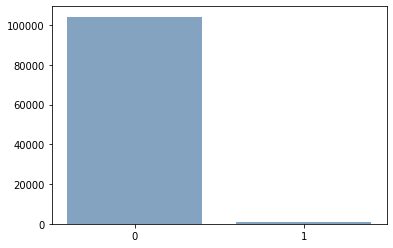

  0%|          | 0/105320 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/6702 [00:00<?, ?it/s]

DISTRIBUTION AFTER UNDERSAMPLING


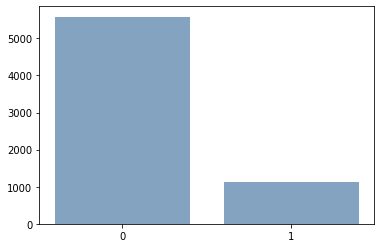

Dataset After Reampling
positives = 1117, negatives: 5585   ration: 1/5


In [191]:
if 'impression_train' in locals(): del impression_train
if 'impression_validat' in locals(): del impression_validate
if 'impression_test' in locals(): del impression_test
if 'data' in locals(): del data
gc.collect()

data = LoadInformation()
impression_train, impression_validate, impression_test =  data.createNewData(window = 10)
del data

''' UNDERSAPING DATA '''

print(f'Original Dataset')
zero, ones = verifyDataset(impression_train, returnEnable = True)
impression_train = undersamplingData(impression_train, ratio = 1 / 5)
print(f'Dataset After Reampling')
verifyDataset(impression_train)

# TESTING MODELS

#### LSTM DATA

In [196]:
__N_EPOCHS_LSTM__ = 1000
__N_BATCHS_LSTM__ = 128

__HIDDEN_SIZE_LSTM__ = 30
__LAYER_SIZE_LSTM__ = 1
__DROPOUT_LSTM__ = 0.5

__LEARNING_RATE_LSTM__ = 3.3e-4
__TYPE_METRIC_LSTM__ = 'PRC' #"AUROC" 'recall' 'f1' 'PRC'
__LOSS_FUNCTION_LSTM__ ='BCE'#'BCE''CB'  "FL" ""

__EARLY_STOP_LSTM__ = True
__PATIENTE_LSTM__ = 10

__SHOW_PROCESS_LSTM__ = True
__PROCESS_FACTOR_LSTM__ = 50

#### GRU DATA

In [208]:
__N_EPOCHS_GRU__ = 1000
__N_BATCHS_GRU__ = 64
__HIDDEN_SIZE_GRU__ = 30
__LAYER_SIZE_GRU__ = 1
__DROPOUT_GRU__ = 0.5

__LEARNING_RATE_GRU__ = 1.3e-4
__TYPE_METRIC_GRU__ = 'PRC' #"AUROC" 'recall' 'f1'
__LOSS_FUNCTION_GRU__ ='BCE'#'BCE''CB'  "FL"
__MODEL_GRU__ ='gru'


__EARLY_STOP_GRU__ = True
__PATIENTE_GRU__ = 10


__SHOW_PROCESS_GRU__ = True
__PROCESS_FACTOR_GRU__ = 50

#### TRANSFORMERS DATA

In [209]:

__N_EPOCHS_TR__ = 1000
__N_BATCHS_TR__ = 64
__LEARNING_RATE_TR__ = 1.2e-4
__MODEL_TR__ ='transformer'
__TYPE_METRIC_TR__ = 'PRC' #"AUROC" 'recall' 'f1'
__LOSS_FUNCTION_TR__ ='BCE'#'BCE''CB'  "FL"
__N_HEADS__ = 9

__EARLY_STOP_TR__ = True
__PATIENTE_TR__ = 10


__SHOW_PROCESS_TR__ = True
__PROCESS_FACTOR_TR__ = 50

### WINDOW = 10

#### Bi-LSTM  Window = 10

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 49 / 53 | Training loss: 0.57222 |  Training PRC: 0.17708
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.50403 |  Validation PRC: 0.00681
Training Stage ==> Epoch: 1 / 999 | Step: 49 / 53 | Training loss: 0.42138 |  Training PRC: 0.15733
Validation Stage ==> Epoch: 1 / 999 | Validation loss: 0.24262 |  Validation PRC: 0.00737
Training Stage ==> Epoch: 2 / 999 | Step: 49 / 53 | Training loss: 0.39551 |  Training PRC: 0.36447
Validation Stage ==> Epoch: 2 / 999 | Validation loss: 0.19871 |  Validation PRC: 0.02444
Training Stage ==> Epoch: 3 / 999 | Step: 49 / 53 | Training loss: 0.37616 |  Training PRC: 0.73663
Validation Stage ==> Epoch: 3 / 999 | Validation loss: 0.18587 |  Validation PRC: 0.03160
Training Stage ==> Epoch: 4 / 999 | Step: 49 / 53 | Training loss: 0.34062 |  Training PRC: 0.78803
Validation Stage ==> Epoch: 4 / 999 | Validation loss: 0.19188 |  Validation PRC: 0.03214
Training Stage ==> Epoch: 5 / 999 | Step: 49 / 53 

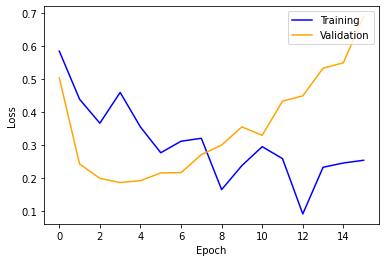

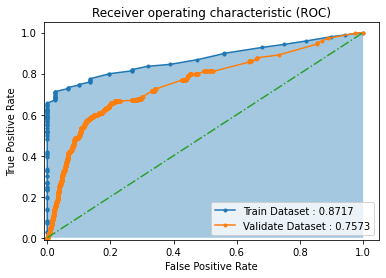

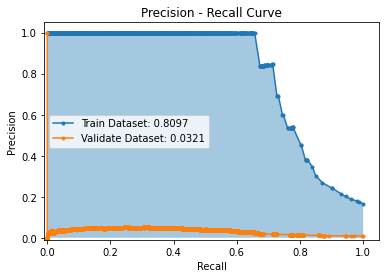

Best Threshold f1 0.399
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 0.20448705554008484 |  PRC: 0.18297566316851277 | precision: 0.06732673267326733 |recall: 0.2905982905982906 | f1_score: 0.10932475884244375 | AUROC: 0.62226510774046
Confusion Matrix
19506 942 166 68
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     20448
         1.0       0.07      0.29      0.11       234

    accuracy                           0.95     20682
   macro avg       0.53      0.62      0.54     20682
weighted avg       0.98      0.95      0.96     20682



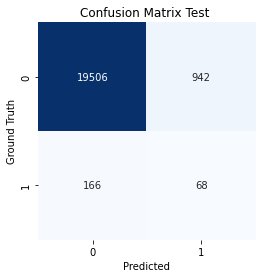

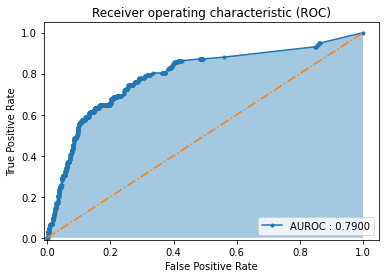

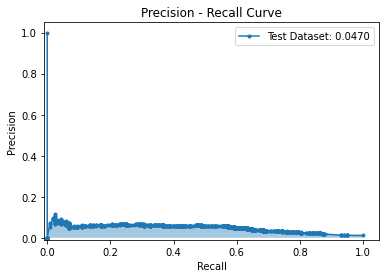

In [201]:
# CLEAN MEMORY AND GPU
torch.cuda.empty_cache()
if 'BiLSTM' in locals():
    del BiLSTM
    gc.collect()


BiLSTM = AIModel(
    impression_train, 
    impression_validate, 
    impression_test, 
    epoch = __N_EPOCHS_LSTM__, 
    batch_size = __N_BATCHS_LSTM__ , 
    hidden_size = __HIDDEN_SIZE_LSTM__, 
    layer_size = __LAYER_SIZE_LSTM__, 
    dropout = __DROPOUT_LSTM__, 
    learning_rate= __LEARNING_RATE_LSTM__,
    typeMetric = __TYPE_METRIC_LSTM__,
    lossFunction = __LOSS_FUNCTION_LSTM__,
    earlyStopFlag = __EARLY_STOP_LSTM__,
    device = __TEST_DEVICE__
    )

BiLSTM.trainModel(
    show_process = __SHOW_PROCESS_LSTM__, 
    patiente = __PATIENTE_LSTM__,
    process_factor = __PROCESS_FACTOR_LSTM__
    )

BiLSTM.plot_Acc_loss()
BiLSTM.ROC_curves()
BiLSTM.PRC_curves()

th, _ = BiLSTM.testModel_GetThreshold(BiLSTM.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
BiLSTM.testModel(BiLSTM.test, showMetrics = True, threshold = th, threshold_flag=True)
BiLSTM.ConfusionMatrixPlotIndividual(BiLSTM.test, threshold = th, threshold_flag=True)
BiLSTM.ROC_plot(BiLSTM.test, thresholdCompare = th)
BiLSTM.PRC_plot(BiLSTM.test, thresholdCompare = th)



In [ ]:
torch.save(BiLSTM.model, 'BiLSTM10')
if 'BiLSTM' in locals():
    del BiLSTM
    gc.collect()

#### GRU WINDOWS 10

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 49 / 105 | Training loss: 0.63190 |  Training PRC: 0.12814
Training Stage ==> Epoch: 0 / 999 | Step: 99 / 105 | Training loss: 0.55664 |  Training PRC: 0.13852
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.51754 |  Validation PRC: 0.00638
Training Stage ==> Epoch: 1 / 999 | Step: 49 / 105 | Training loss: 0.52828 |  Training PRC: 0.14244
Training Stage ==> Epoch: 1 / 999 | Step: 99 / 105 | Training loss: 0.57256 |  Training PRC: 0.14856
Validation Stage ==> Epoch: 1 / 999 | Validation loss: 0.36688 |  Validation PRC: 0.00695
Training Stage ==> Epoch: 2 / 999 | Step: 49 / 105 | Training loss: 0.42179 |  Training PRC: 0.20040
Training Stage ==> Epoch: 2 / 999 | Step: 99 / 105 | Training loss: 0.41005 |  Training PRC: 0.18979
Validation Stage ==> Epoch: 2 / 999 | Validation loss: 0.22585 |  Validation PRC: 0.01188
Training Stage ==> Epoch: 3 / 999 | Step: 49 / 105 | Training loss: 0.49427 |  Training PRC: 0.50311
Training Stage ==> Epoc

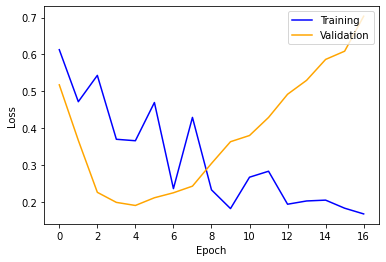

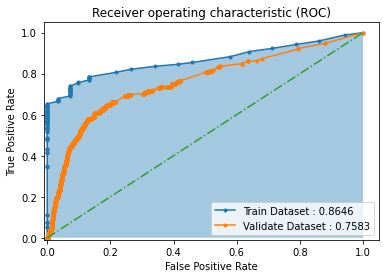

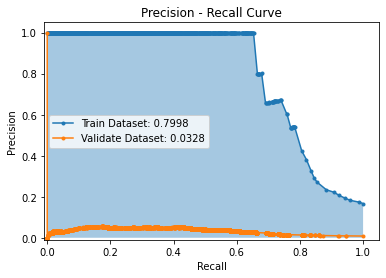

Best Threshold f1 0.41100000000000003
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 0.22949929535388947 |  PRC: 0.23967380234377827 | precision: 0.06241872561768531 |recall: 0.41025641025641024 | f1_score: 0.10835214446952596 | AUROC: 0.6698680329842301
Confusion Matrix
19006 1442 138 96
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     20448
         1.0       0.06      0.41      0.11       234

    accuracy                           0.92     20682
   macro avg       0.53      0.67      0.53     20682
weighted avg       0.98      0.92      0.95     20682



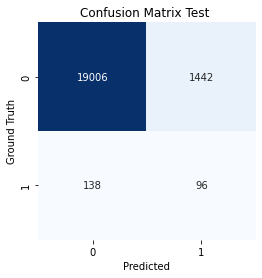

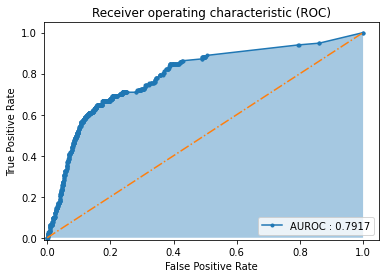

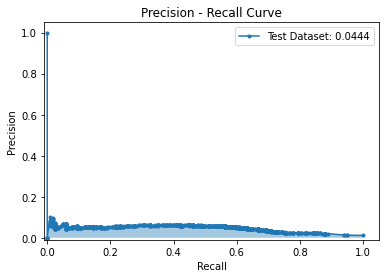

In [210]:
torch.cuda.empty_cache() 

if 'BiGRU' in locals():
    del BiGRU
    gc.collect()

BiGRU = AIModel(
    impression_train, 
    impression_validate, 
    impression_test, 
    epoch = __N_EPOCHS_GRU__, 
    batch_size = __N_BATCHS_GRU__ , 
    hidden_size = __HIDDEN_SIZE_GRU__, 
    layer_size = __LAYER_SIZE_GRU__, 
    dropout = __DROPOUT_GRU__, 
    
    learning_rate= __LEARNING_RATE_GRU__,
    typeMetric = __TYPE_METRIC_GRU__,
    lossFunction = __LOSS_FUNCTION_GRU__,
    earlyStopFlag = __EARLY_STOP_GRU__,
    model = __MODEL_GRU__,
    device=__TEST_DEVICE__
    )

BiGRU.trainModel(
    show_process = __SHOW_PROCESS_GRU__, 
    patiente = __PATIENTE_GRU__,
    process_factor = __PROCESS_FACTOR_GRU__
    )

BiGRU.plot_Acc_loss()
BiGRU.ROC_curves()
BiGRU.PRC_curves()


th, _ = BiGRU.testModel_GetThreshold(BiGRU.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
BiGRU.testModel(BiGRU.test, showMetrics = True, threshold = th, threshold_flag=True)
BiGRU.ConfusionMatrixPlotIndividual(BiGRU.test, threshold = th, threshold_flag=True)
BiGRU.ROC_plot(BiGRU.test, thresholdCompare = th)
BiGRU.PRC_plot(BiGRU.test, thresholdCompare = th)

torch.cuda.empty_cache() 

In [ ]:
torch.save(BiGRU.model, 'BiGRU10')
if 'BiGRU' in locals():
    del BiGRU
    gc.collect()

#### TRANSFORMER WINDOW= 10

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 49 / 105 | Training loss: 0.40740 |  Training PRC: 0.24738
Training Stage ==> Epoch: 0 / 999 | Step: 99 / 105 | Training loss: 0.59444 |  Training PRC: 0.26632
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.21381 |  Validation PRC: 0.00929
Training Stage ==> Epoch: 1 / 999 | Step: 49 / 105 | Training loss: 0.45779 |  Training PRC: 0.40935
Training Stage ==> Epoch: 1 / 999 | Step: 99 / 105 | Training loss: 0.32209 |  Training PRC: 0.45747
Validation Stage ==> Epoch: 1 / 999 | Validation loss: 0.25861 |  Validation PRC: 0.01174
Training Stage ==> Epoch: 2 / 999 | Step: 49 / 105 | Training loss: 0.25038 |  Training PRC: 0.52659
Training Stage ==> Epoch: 2 / 999 | Step: 99 / 105 | Training loss: 0.32378 |  Training PRC: 0.56613
Validation Stage ==> Epoch: 2 / 999 | Validation loss: 0.40720 |  Validation PRC: 0.01591
Training Stage ==> Epoch: 3 / 999 | Step: 49 / 105 | Training loss: 0.24421 |  Training PRC: 0.67523
Training Stage ==> Epoc

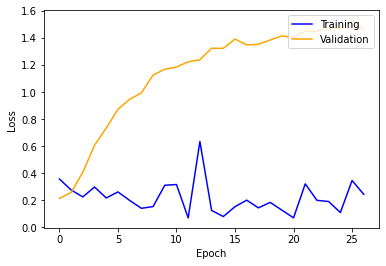

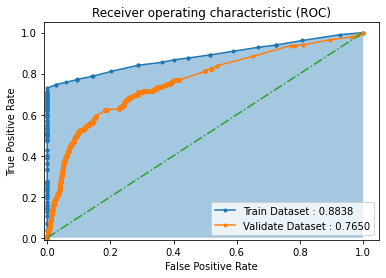

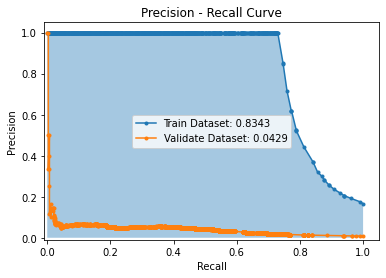

Best Threshold f1 0.997
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 1.7444175481796265 |  PRC: 0.3267068239807792 | precision: 0.05057803468208093 |recall: 0.5982905982905983 | f1_score: 0.0932711525649567 | AUROC: 0.7348847357650174
Confusion Matrix
17820 2628 94 140
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93     20448
         1.0       0.05      0.60      0.09       234

    accuracy                           0.87     20682
   macro avg       0.52      0.73      0.51     20682
weighted avg       0.98      0.87      0.92     20682



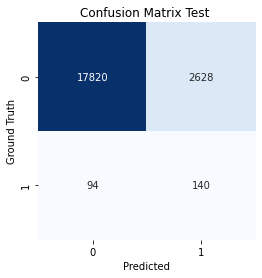

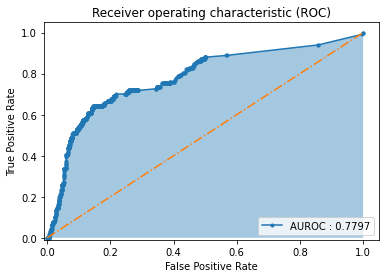

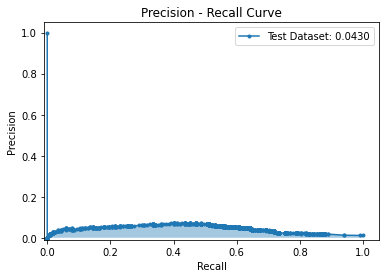

In [211]:

torch.cuda.empty_cache()

if 'tr' in locals():
    del tr
    gc.collect()

tr = AIModel(
    impression_train, 
    impression_validate, 
    impression_test, 
    epoch = __N_EPOCHS_TR__, 
    batch_size = __N_BATCHS_TR__, 
    learning_rate= __LEARNING_RATE_TR__, 
    model = __MODEL_TR__,
    typeMetric = __TYPE_METRIC_TR__,
    lossFunction = __LOSS_FUNCTION_TR__,
    earlyStopFlag = __EARLY_STOP_TR__,
    nhead= __N_HEADS__,
    device=__TEST_DEVICE__
    )
    

tr.trainModel(
    show_process = __SHOW_PROCESS_TR__, 
    patiente = __PATIENTE_TR__,
    process_factor = __PROCESS_FACTOR_TR__)

tr.plot_Acc_loss()
tr.ROC_curves()
tr.PRC_curves()

th, _ = tr.testModel_GetThreshold(tr.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
tr.testModel(tr.test, showMetrics = True, threshold = th, threshold_flag=True)
tr.ConfusionMatrixPlotIndividual(tr.test, threshold = th, threshold_flag=True)
tr.ROC_plot(tr.test, thresholdCompare = th)
tr.PRC_plot(tr.test, thresholdCompare = th)


torch.cuda.empty_cache() 

In [ ]:
torch.save(tr.model, 'tr10')
if 'tr' in locals():
    del tr
    gc.collect()

## WINDOW = 5

Original Dataset
positives = 1117, negatives: 104203   ration: 1/93
DISTRIBUTION BEFORE UNDERSAMPLING


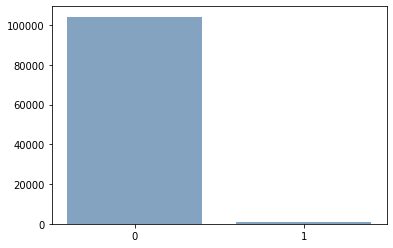

  0%|          | 0/105320 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/6702 [00:00<?, ?it/s]

DISTRIBUTION AFTER UNDERSAMPLING


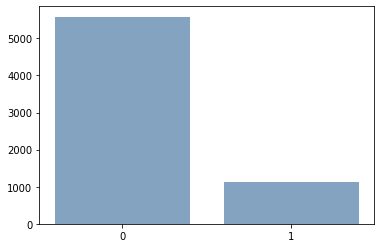

Dataset After Reampling
positives = 1117, negatives: 5585   ration: 1/5


In [213]:
if 'impression_train' in locals(): del impression_train
if 'impression_validat' in locals(): del impression_validate
if 'impression_test' in locals(): del impression_test
if 'data' in locals(): del data
gc.collect()

data = LoadInformation()
impression_train, impression_validate, impression_test =  data.createNewData(window = 5)
del data

''' UNDERSAPING DATA '''

print(f'Original Dataset')
zero, ones = verifyDataset(impression_train, returnEnable = True)
impression_train = undersamplingData(impression_train, ratio = 1 / 5, window = 5)
print(f'Dataset After Reampling')
verifyDataset(impression_train)

##### Bi-LSTM WINDOWS = 5  

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 49 / 53 | Training loss: 0.63250 |  Training PRC: 0.19100
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.56246 |  Validation PRC: 0.00696
Training Stage ==> Epoch: 1 / 999 | Step: 49 / 53 | Training loss: 0.49036 |  Training PRC: 0.16499
Validation Stage ==> Epoch: 1 / 999 | Validation loss: 0.36051 |  Validation PRC: 0.00736
Training Stage ==> Epoch: 2 / 999 | Step: 49 / 53 | Training loss: 0.52161 |  Training PRC: 0.18858
Validation Stage ==> Epoch: 2 / 999 | Validation loss: 0.21120 |  Validation PRC: 0.01831
Training Stage ==> Epoch: 3 / 999 | Step: 49 / 53 | Training loss: 0.38488 |  Training PRC: 0.74454
Validation Stage ==> Epoch: 3 / 999 | Validation loss: 0.18708 |  Validation PRC: 0.02801
Training Stage ==> Epoch: 4 / 999 | Step: 49 / 53 | Training loss: 0.38379 |  Training PRC: 0.80373
Validation Stage ==> Epoch: 4 / 999 | Validation loss: 0.21750 |  Validation PRC: 0.02743
Training Stage ==> Epoch: 5 / 999 | Step: 49 / 53 

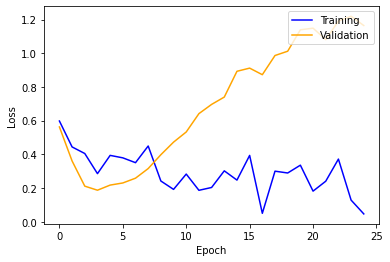

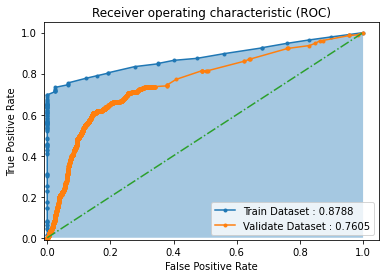

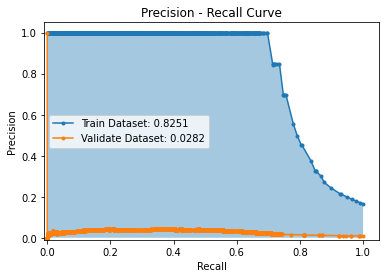

Best Threshold f1 0.967
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 0.8619768023490906 |  PRC: 0.24093940033841357 | precision: 0.08185053380782918 |recall: 0.39316239316239315 | f1_score: 0.13549337260677466 | AUROC: 0.6713464547971589
Confusion Matrix
19416 1032 142 92
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     20448
         1.0       0.08      0.39      0.14       234

    accuracy                           0.94     20682
   macro avg       0.54      0.67      0.55     20682
weighted avg       0.98      0.94      0.96     20682



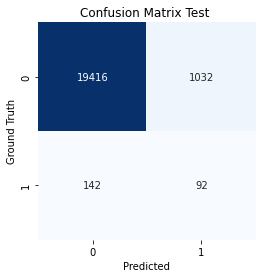

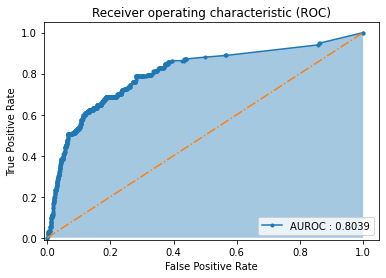

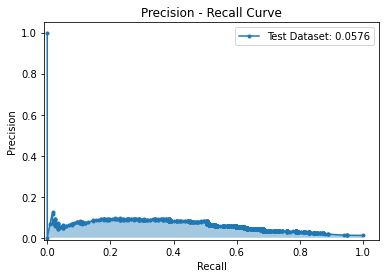

In [215]:
# CLEAN MEMORY AND GPU
torch.cuda.empty_cache()
if 'BiLSTM' in locals():
    del BiLSTM
    gc.collect()


BiLSTM = AIModel(
    impression_train, 
    impression_validate, 
    impression_test, 
    epoch = __N_EPOCHS_LSTM__, 
    batch_size = __N_BATCHS_LSTM__ , 
    hidden_size = __HIDDEN_SIZE_LSTM__, 
    layer_size = __LAYER_SIZE_LSTM__, 
    dropout = __DROPOUT_LSTM__, 
    learning_rate= __LEARNING_RATE_LSTM__,
    typeMetric = __TYPE_METRIC_LSTM__,
    lossFunction = __LOSS_FUNCTION_LSTM__,
    earlyStopFlag = __EARLY_STOP_LSTM__,
    device = __TEST_DEVICE__
    )

BiLSTM.trainModel(
    show_process = __SHOW_PROCESS_LSTM__, 
    patiente = __PATIENTE_LSTM__,
    process_factor = __PROCESS_FACTOR_LSTM__
    )

BiLSTM.plot_Acc_loss()
BiLSTM.ROC_curves()
BiLSTM.PRC_curves()

th, _ = BiLSTM.testModel_GetThreshold(BiLSTM.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
BiLSTM.testModel(BiLSTM.test, showMetrics = True, threshold = th, threshold_flag=True)
BiLSTM.ConfusionMatrixPlotIndividual(BiLSTM.test, threshold = th, threshold_flag=True)
BiLSTM.ROC_plot(BiLSTM.test, thresholdCompare = th)
BiLSTM.PRC_plot(BiLSTM.test, thresholdCompare = th)



In [ ]:
torch.save(BiLSTM.model, 'BiLSTM5')
if 'BiLSTM' in locals():
    del BiLSTM
    gc.collect()

#### Bi-GRU Window = 5

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 49 / 105 | Training loss: 0.60047 |  Training PRC: 0.17089
Training Stage ==> Epoch: 0 / 999 | Step: 99 / 105 | Training loss: 0.57651 |  Training PRC: 0.16792
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.46799 |  Validation PRC: 0.00870
Training Stage ==> Epoch: 1 / 999 | Step: 49 / 105 | Training loss: 0.53388 |  Training PRC: 0.19521
Training Stage ==> Epoch: 1 / 999 | Step: 99 / 105 | Training loss: 0.51498 |  Training PRC: 0.19564
Validation Stage ==> Epoch: 1 / 999 | Validation loss: 0.34465 |  Validation PRC: 0.00937
Training Stage ==> Epoch: 2 / 999 | Step: 49 / 105 | Training loss: 0.46280 |  Training PRC: 0.30133
Training Stage ==> Epoch: 2 / 999 | Step: 99 / 105 | Training loss: 0.43092 |  Training PRC: 0.30773
Validation Stage ==> Epoch: 2 / 999 | Validation loss: 0.25299 |  Validation PRC: 0.01381
Training Stage ==> Epoch: 3 / 999 | Step: 49 / 105 | Training loss: 0.37349 |  Training PRC: 0.57386
Training Stage ==> Epoc

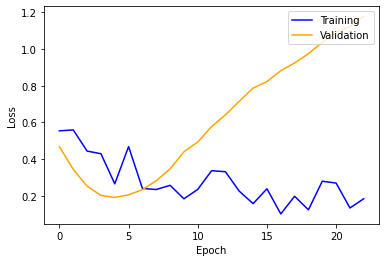

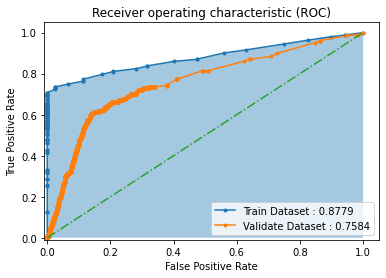

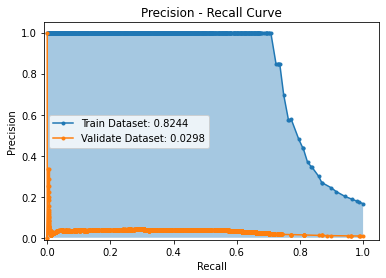

Best Threshold f1 0.9480000000000001
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 0.6638973951339722 |  PRC: 0.21136046283961105 | precision: 0.07339449541284404 |recall: 0.3418803418803419 | f1_score: 0.12084592145015106 | AUROC: 0.6462433790778862
Confusion Matrix
19438 1010 154 80
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     20448
         1.0       0.07      0.34      0.12       234

    accuracy                           0.94     20682
   macro avg       0.53      0.65      0.55     20682
weighted avg       0.98      0.94      0.96     20682



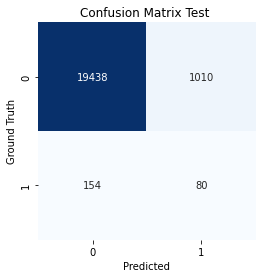

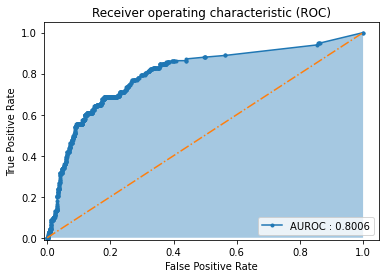

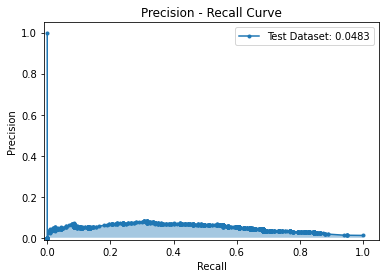

In [216]:
torch.cuda.empty_cache() 

if 'BiGRU' in locals():
    del BiGRU
    gc.collect()

BiGRU = AIModel(
    impression_train, 
    impression_validate, 
    impression_test, 
    epoch = __N_EPOCHS_GRU__, 
    batch_size = __N_BATCHS_GRU__ , 
    hidden_size = __HIDDEN_SIZE_GRU__, 
    layer_size = __LAYER_SIZE_GRU__, 
    dropout = __DROPOUT_GRU__, 
    
    learning_rate= __LEARNING_RATE_GRU__,
    typeMetric = __TYPE_METRIC_GRU__,
    lossFunction = __LOSS_FUNCTION_GRU__,
    earlyStopFlag = __EARLY_STOP_GRU__,
    model = __MODEL_GRU__,
    device=__TEST_DEVICE__
    )

BiGRU.trainModel(
    show_process = __SHOW_PROCESS_GRU__, 
    patiente = __PATIENTE_GRU__,
    process_factor = __PROCESS_FACTOR_GRU__
    )

BiGRU.plot_Acc_loss()
BiGRU.ROC_curves()
BiGRU.PRC_curves()


th, _ = BiGRU.testModel_GetThreshold(BiGRU.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
BiGRU.testModel(BiGRU.test, showMetrics = True, threshold = th, threshold_flag=True)
BiGRU.ConfusionMatrixPlotIndividual(BiGRU.test, threshold = th, threshold_flag=True)
BiGRU.ROC_plot(BiGRU.test, thresholdCompare = th)
BiGRU.PRC_plot(BiGRU.test, thresholdCompare = th)

torch.cuda.empty_cache() 

#### TRANSFORMER WINDOW 5

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 49 / 105 | Training loss: 0.49517 |  Training PRC: 0.21614
Training Stage ==> Epoch: 0 / 999 | Step: 99 / 105 | Training loss: 0.44782 |  Training PRC: 0.25474
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.23604 |  Validation PRC: 0.01130
Training Stage ==> Epoch: 1 / 999 | Step: 49 / 105 | Training loss: 0.41735 |  Training PRC: 0.56912
Training Stage ==> Epoch: 1 / 999 | Step: 99 / 105 | Training loss: 0.52178 |  Training PRC: 0.58379
Validation Stage ==> Epoch: 1 / 999 | Validation loss: 0.43257 |  Validation PRC: 0.01434
Training Stage ==> Epoch: 2 / 999 | Step: 49 / 105 | Training loss: 0.39368 |  Training PRC: 0.67094
Training Stage ==> Epoch: 2 / 999 | Step: 99 / 105 | Training loss: 0.33176 |  Training PRC: 0.68424
Validation Stage ==> Epoch: 2 / 999 | Validation loss: 0.60183 |  Validation PRC: 0.01626
Training Stage ==> Epoch: 3 / 999 | Step: 49 / 105 | Training loss: 0.16607 |  Training PRC: 0.74068
Training Stage ==> Epoc

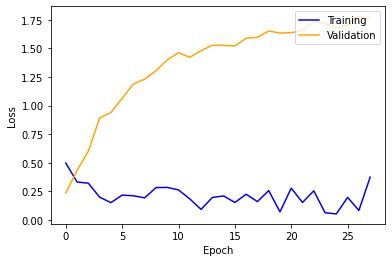

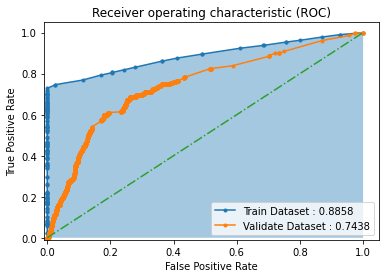

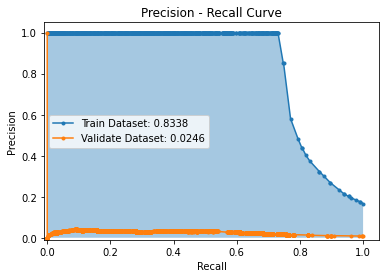

Best Threshold f1 0.999
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 1.9906916618347168 |  PRC: 0.2612543822264895 | precision: 0.054878048780487805 |recall: 0.46153846153846156 | f1_score: 0.09809264305177111 | AUROC: 0.6852880101119538
Confusion Matrix
18588 1860 126 108
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     20448
         1.0       0.05      0.46      0.10       234

    accuracy                           0.90     20682
   macro avg       0.52      0.69      0.52     20682
weighted avg       0.98      0.90      0.94     20682



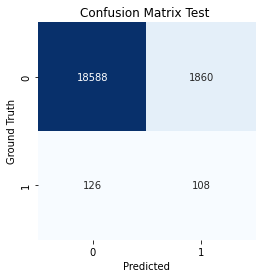

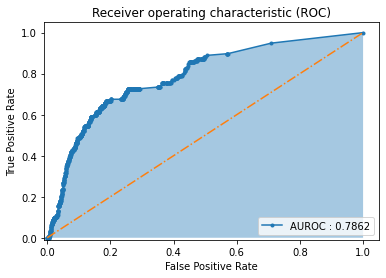

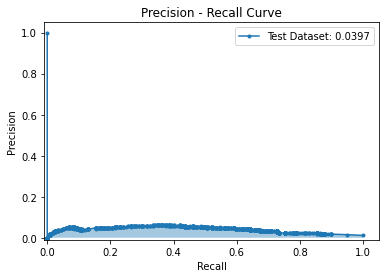

In [217]:

torch.cuda.empty_cache()

if 'tr' in locals():
    del tr
    gc.collect()

tr = AIModel(
    impression_train, 
    impression_validate, 
    impression_test, 
    epoch = __N_EPOCHS_TR__, 
    batch_size = __N_BATCHS_TR__, 
    learning_rate= __LEARNING_RATE_TR__, 
    model = __MODEL_TR__,
    typeMetric = __TYPE_METRIC_TR__,
    lossFunction = __LOSS_FUNCTION_TR__,
    earlyStopFlag = __EARLY_STOP_TR__,
    nhead= __N_HEADS__,
    device=__TEST_DEVICE__
    )
    

tr.trainModel(
    show_process = __SHOW_PROCESS_TR__, 
    patiente = __PATIENTE_TR__,
    process_factor = __PROCESS_FACTOR_TR__)

tr.plot_Acc_loss()
tr.ROC_curves()
tr.PRC_curves()

th, _ = tr.testModel_GetThreshold(tr.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
tr.testModel(tr.test, showMetrics = True, threshold = th, threshold_flag=True)
tr.ConfusionMatrixPlotIndividual(tr.test, threshold = th, threshold_flag=True)
tr.ROC_plot(tr.test, thresholdCompare = th)
tr.PRC_plot(tr.test, thresholdCompare = th)


torch.cuda.empty_cache() 

In [ ]:
torch.save(tr.model, 'tr10')
if 'tr' in locals():
    del tr
    gc.collect()

## WINDOW = 3

Original Dataset
positives = 1117, negatives: 104203   ration: 1/93
DISTRIBUTION BEFORE UNDERSAMPLING


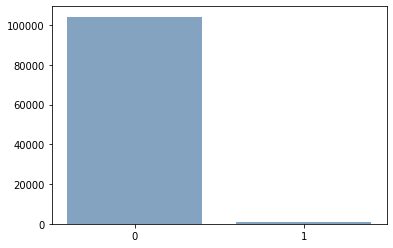

  0%|          | 0/105320 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/6702 [00:00<?, ?it/s]

DISTRIBUTION AFTER UNDERSAMPLING


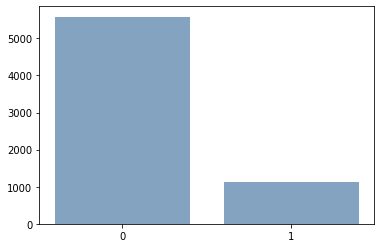

Dataset After Reampling
positives = 1117, negatives: 5585   ration: 1/5


In [218]:
if 'impression_train' in locals(): del impression_train
if 'impression_validat' in locals(): del impression_validate
if 'impression_test' in locals(): del impression_test
if 'data' in locals(): del data
gc.collect()

data = LoadInformation()
impression_train, impression_validate, impression_test =  data.createNewData(window = 3)
del data


''' UNDERSAPING DATA '''

print(f'Original Dataset')
zero, ones = verifyDataset(impression_train, returnEnable = True)
impression_train = undersamplingData(impression_train, ratio = 1 / 5, window = 3)
print(f'Dataset After Reampling')
verifyDataset(impression_train)

#### Bi-LSTM WINDOWS = 3

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 49 / 53 | Training loss: 0.63097 |  Training PRC: 0.15388
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.58545 |  Validation PRC: 0.00730
Training Stage ==> Epoch: 1 / 999 | Step: 49 / 53 | Training loss: 0.54422 |  Training PRC: 0.17396
Validation Stage ==> Epoch: 1 / 999 | Validation loss: 0.44046 |  Validation PRC: 0.00714
Training Stage ==> Epoch: 2 / 999 | Step: 49 / 53 | Training loss: 0.42063 |  Training PRC: 0.23237
Validation Stage ==> Epoch: 2 / 999 | Validation loss: 0.30857 |  Validation PRC: 0.00823
Training Stage ==> Epoch: 3 / 999 | Step: 49 / 53 | Training loss: 0.38672 |  Training PRC: 0.36050
Validation Stage ==> Epoch: 3 / 999 | Validation loss: 0.22784 |  Validation PRC: 0.01311
Training Stage ==> Epoch: 4 / 999 | Step: 49 / 53 | Training loss: 0.37887 |  Training PRC: 0.72894
Validation Stage ==> Epoch: 4 / 999 | Validation loss: 0.20418 |  Validation PRC: 0.02035
Training Stage ==> Epoch: 5 / 999 | Step: 49 / 53 

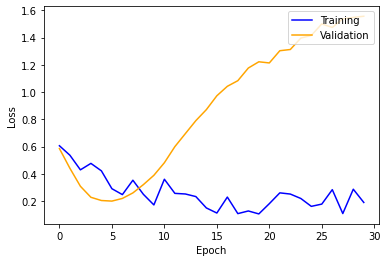

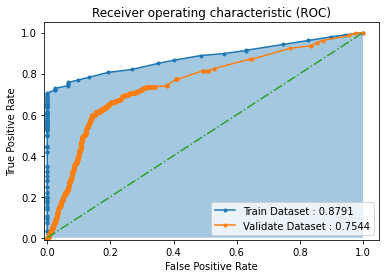

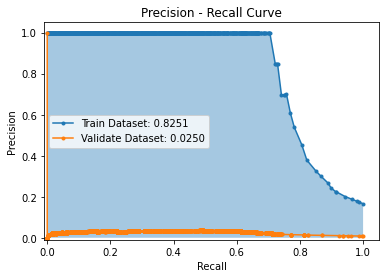

Best Threshold f1 0.988
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 1.342476487159729 |  PRC: 0.29438736414712346 | precision: 0.061991869918699184 |recall: 0.5213675213675214 | f1_score: 0.11080835603996367 | AUROC: 0.7155448717948717
Confusion Matrix
18602 1846 112 122
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     20448
         1.0       0.06      0.52      0.11       234

    accuracy                           0.91     20682
   macro avg       0.53      0.72      0.53     20682
weighted avg       0.98      0.91      0.94     20682



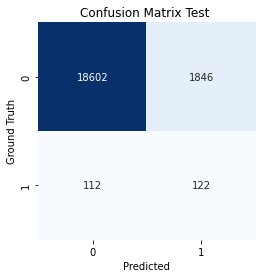

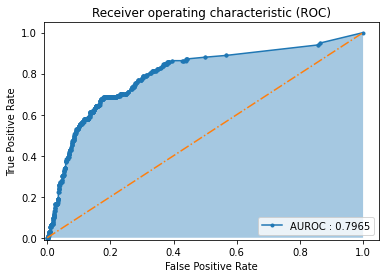

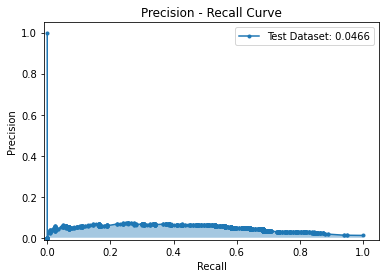

In [219]:
# CLEAN MEMORY AND GPU
torch.cuda.empty_cache()
if 'BiLSTM' in locals():
    del BiLSTM
    gc.collect()


BiLSTM = AIModel(
    impression_train, 
    impression_validate, 
    impression_test, 
    epoch = __N_EPOCHS_LSTM__, 
    batch_size = __N_BATCHS_LSTM__ , 
    hidden_size = __HIDDEN_SIZE_LSTM__, 
    layer_size = __LAYER_SIZE_LSTM__, 
    dropout = __DROPOUT_LSTM__, 
    learning_rate= __LEARNING_RATE_LSTM__,
    typeMetric = __TYPE_METRIC_LSTM__,
    lossFunction = __LOSS_FUNCTION_LSTM__,
    earlyStopFlag = __EARLY_STOP_LSTM__,
    device = __TEST_DEVICE__
    )

BiLSTM.trainModel(
    show_process = __SHOW_PROCESS_LSTM__, 
    patiente = __PATIENTE_LSTM__,
    process_factor = __PROCESS_FACTOR_LSTM__
    )

BiLSTM.plot_Acc_loss()
BiLSTM.ROC_curves()
BiLSTM.PRC_curves()

th, _ = BiLSTM.testModel_GetThreshold(BiLSTM.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
BiLSTM.testModel(BiLSTM.test, showMetrics = True, threshold = th, threshold_flag=True)
BiLSTM.ConfusionMatrixPlotIndividual(BiLSTM.test, threshold = th, threshold_flag=True)
BiLSTM.ROC_plot(BiLSTM.test, thresholdCompare = th)
BiLSTM.PRC_plot(BiLSTM.test, thresholdCompare = th)



In [ ]:
torch.save(BiLSTM.model, 'BiLSTM3')
if 'BiLSTM' in locals():
    del BiLSTM
    gc.collect()

#### Bi-GRU WINDOW = 3

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 49 / 105 | Training loss: 0.64405 |  Training PRC: 0.20222
Training Stage ==> Epoch: 0 / 999 | Step: 99 / 105 | Training loss: 0.60924 |  Training PRC: 0.18821
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.56409 |  Validation PRC: 0.00822
Training Stage ==> Epoch: 1 / 999 | Step: 49 / 105 | Training loss: 0.57942 |  Training PRC: 0.18318
Training Stage ==> Epoch: 1 / 999 | Step: 99 / 105 | Training loss: 0.51741 |  Training PRC: 0.18175
Validation Stage ==> Epoch: 1 / 999 | Validation loss: 0.44395 |  Validation PRC: 0.00841
Training Stage ==> Epoch: 2 / 999 | Step: 49 / 105 | Training loss: 0.46858 |  Training PRC: 0.21264
Training Stage ==> Epoch: 2 / 999 | Step: 99 / 105 | Training loss: 0.44967 |  Training PRC: 0.20517
Validation Stage ==> Epoch: 2 / 999 | Validation loss: 0.34689 |  Validation PRC: 0.00851
Training Stage ==> Epoch: 3 / 999 | Step: 49 / 105 | Training loss: 0.51494 |  Training PRC: 0.26849
Training Stage ==> Epoc

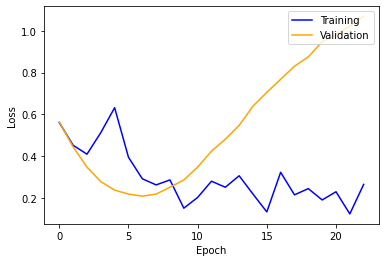

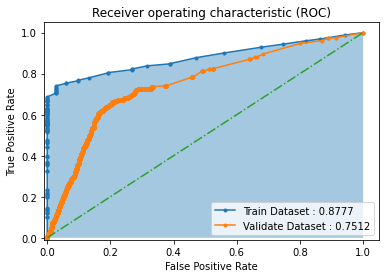

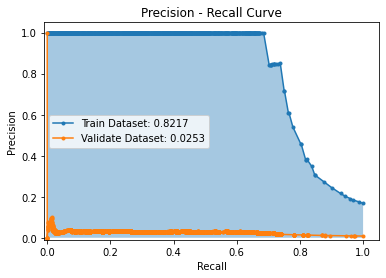

Best Threshold f1 0.8190000000000001
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 0.4846411645412445 |  PRC: 0.23221547696090777 | precision: 0.055952380952380955 |recall: 0.4017094017094017 | f1_score: 0.09822361546499477 | AUROC: 0.6620734019501624
Confusion Matrix
18862 1586 140 94
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96     20448
         1.0       0.06      0.40      0.10       234

    accuracy                           0.92     20682
   macro avg       0.52      0.66      0.53     20682
weighted avg       0.98      0.92      0.95     20682



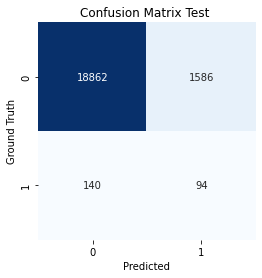

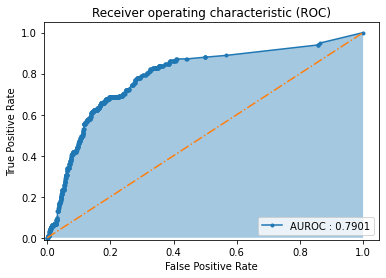

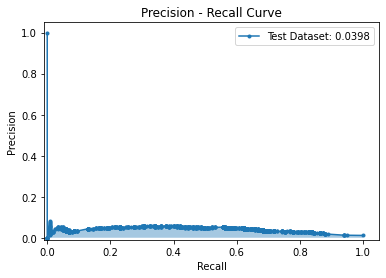

In [220]:
torch.cuda.empty_cache() 

if 'BiGRU' in locals():
    del BiGRU
    gc.collect()

BiGRU = AIModel(
    impression_train, 
    impression_validate, 
    impression_test, 
    epoch = __N_EPOCHS_GRU__, 
    batch_size = __N_BATCHS_GRU__ , 
    hidden_size = __HIDDEN_SIZE_GRU__, 
    layer_size = __LAYER_SIZE_GRU__, 
    dropout = __DROPOUT_GRU__, 
    
    learning_rate= __LEARNING_RATE_GRU__,
    typeMetric = __TYPE_METRIC_GRU__,
    lossFunction = __LOSS_FUNCTION_GRU__,
    earlyStopFlag = __EARLY_STOP_GRU__,
    model = __MODEL_GRU__,
    device=__TEST_DEVICE__
    )

BiGRU.trainModel(
    show_process = __SHOW_PROCESS_GRU__, 
    patiente = __PATIENTE_GRU__,
    process_factor = __PROCESS_FACTOR_GRU__
    )

BiGRU.plot_Acc_loss()
BiGRU.ROC_curves()
BiGRU.PRC_curves()


th, _ = BiGRU.testModel_GetThreshold(BiGRU.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
BiGRU.testModel(BiGRU.test, showMetrics = True, threshold = th, threshold_flag=True)
BiGRU.ConfusionMatrixPlotIndividual(BiGRU.test, threshold = th, threshold_flag=True)
BiGRU.ROC_plot(BiGRU.test, thresholdCompare = th)
BiGRU.PRC_plot(BiGRU.test, thresholdCompare = th)

torch.cuda.empty_cache() 

In [ ]:
torch.save(BiGRU.model, 'BiGRU10')
if 'BiGRU' in locals():
    del BiGRU
    gc.collect()

#### TRANSFORMER WINDOWS = 3

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 49 / 105 | Training loss: 0.46832 |  Training PRC: 0.22004
Training Stage ==> Epoch: 0 / 999 | Step: 99 / 105 | Training loss: 0.36761 |  Training PRC: 0.25795
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.26622 |  Validation PRC: 0.01116
Training Stage ==> Epoch: 1 / 999 | Step: 49 / 105 | Training loss: 0.37252 |  Training PRC: 0.49591
Training Stage ==> Epoch: 1 / 999 | Step: 99 / 105 | Training loss: 0.31160 |  Training PRC: 0.53854
Validation Stage ==> Epoch: 1 / 999 | Validation loss: 0.40109 |  Validation PRC: 0.01298
Training Stage ==> Epoch: 2 / 999 | Step: 49 / 105 | Training loss: 0.31211 |  Training PRC: 0.59875
Training Stage ==> Epoch: 2 / 999 | Step: 99 / 105 | Training loss: 0.39993 |  Training PRC: 0.61179
Validation Stage ==> Epoch: 2 / 999 | Validation loss: 0.55819 |  Validation PRC: 0.01414
Training Stage ==> Epoch: 3 / 999 | Step: 49 / 105 | Training loss: 0.37461 |  Training PRC: 0.65803
Training Stage ==> Epoc

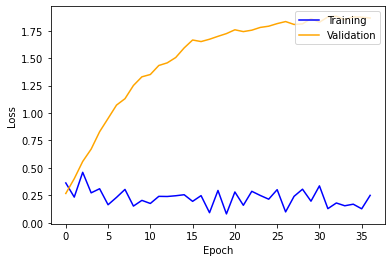

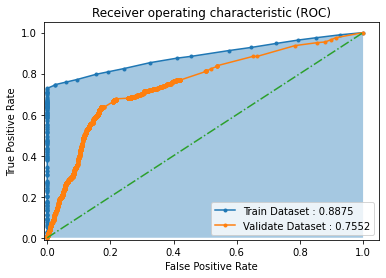

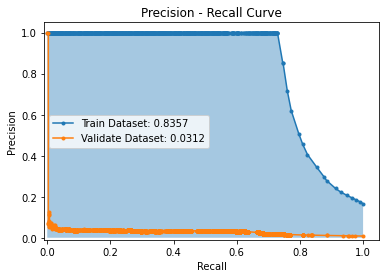

Best Threshold f1 0.998
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 2.159195899963379 |  PRC: 0.2984789468167389 | precision: 0.03637381085618355 |recall: 0.5555555555555556 | f1_score: 0.06827731092436976 | AUROC: 0.6935641627543035
Confusion Matrix
17004 3444 104 130
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91     20448
         1.0       0.04      0.56      0.07       234

    accuracy                           0.83     20682
   macro avg       0.52      0.69      0.49     20682
weighted avg       0.98      0.83      0.90     20682



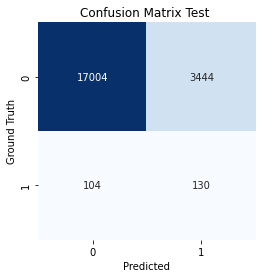

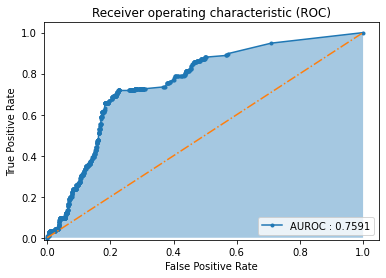

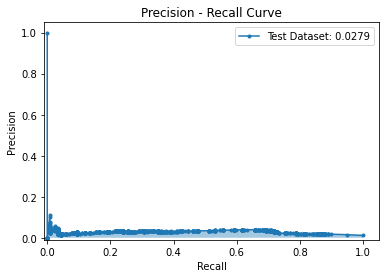

In [221]:

torch.cuda.empty_cache()

if 'tr' in locals():
    del tr
    gc.collect()

tr = AIModel(
    impression_train, 
    impression_validate, 
    impression_test, 
    epoch = __N_EPOCHS_TR__, 
    batch_size = __N_BATCHS_TR__, 
    learning_rate= __LEARNING_RATE_TR__, 
    model = __MODEL_TR__,
    typeMetric = __TYPE_METRIC_TR__,
    lossFunction = __LOSS_FUNCTION_TR__,
    earlyStopFlag = __EARLY_STOP_TR__,
    nhead= __N_HEADS__,
    device=__TEST_DEVICE__
    )
    

tr.trainModel(
    show_process = __SHOW_PROCESS_TR__, 
    patiente = __PATIENTE_TR__,
    process_factor = __PROCESS_FACTOR_TR__)

tr.plot_Acc_loss()
tr.ROC_curves()
tr.PRC_curves()

th, _ = tr.testModel_GetThreshold(tr.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
tr.testModel(tr.test, showMetrics = True, threshold = th, threshold_flag=True)
tr.ConfusionMatrixPlotIndividual(tr.test, threshold = th, threshold_flag=True)
tr.ROC_plot(tr.test, thresholdCompare = th)
tr.PRC_plot(tr.test, thresholdCompare = th)


torch.cuda.empty_cache() 

In [ ]:
torch.save(tr.model, 'tr10')
if 'tr' in locals():
    del tr
    gc.collect()

# BONUS TEST

In [20]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import warnings 
warnings.filterwarnings('ignore')

'''
Import pytorch lybraries
'''
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

''' 
Import modules for PRC and AUROC
ROC Curve AUC
PRC Curve
'''
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
import seaborn as sns

from tqdm.notebook import tqdm_notebook
import math
import gc


# Define Device
__TEST_DEVICE__ = 'gpu'

class LoadInformationBonus():
    def __init__(self):
        self.newList =  pd.read_csv('./news_list.csv')
        self.newList['datePublished'] = pd.to_datetime(self.newList['datePublished'])
        '''
        Fill missing data  in by space
        '''
        self.newList['keywords'] = self.newList['keywords'].fillna(value = '')
        '''
        Set date time as index
        '''
        self.newList.set_index('news_index_encode', inplace =True)
        
        self.impression =  pd.read_json('./impression_v3.json')
        self.impression.set_index('impression_time', inplace = True)
        self.impression.index.names = ['Date']
        

    '''
        Function to return a section of the data based on date and time
        data : dataset
        start: starting time
        end: ending time
    '''
    def SplitData(self, data, start, end):
        if end == '':
            return data.loc[start::, :]
        return data.loc[start:end, :]


    def  createNewData(self,  window = 10):
        '''
            Extract information required
            combine ‘target_news_onehot’ after ‘click_seq_10_onehot’
        '''
        impressionMerged = []

        for (target_news_onehot, click_seq_10_onehot) in self.impression[['target_news_onehot', 'click_seq_10_onehot']].values:
            if window <= len(click_seq_10_onehot):
                init = len(click_seq_10_onehot)  - window
                end = len(click_seq_10_onehot) 
                get_click_seq_10_onehot = click_seq_10_onehot[init : end]
                get_click_seq_10_onehot.append(target_news_onehot)
                get_click_seq_10_onehot = np.array(get_click_seq_10_onehot)
                
                impressionMerged.append(get_click_seq_10_onehot)
            else:
                break


        ''' 
            insert the combination into the original dataframe
        '''
        self.impression["click_seq_10_onehot_combined"] = impressionMerged

        ''' 
            Create a new variable to extract the combined data and y
        '''
        impression = self.impression.loc[:, self.impression.columns.isin(['click_seq_10_onehot_combined', 'y'])]   
        return impression


def getDataWindow(data, window = 10):
    newList = []
    window += 1

    for i in data:
        l = i.shape[0]
        extract = i[l - window: l, :]
        newList.append(extract)

    return newList

def SplitDataByDate(data, start, end):
    if end == '':
        return data.loc[start::, :]
    return data.loc[start:end, :]


def splitData(data):
    ''' 
        Split Data into Train, Validate, Test
    '''

    impression_train = SplitDataByDate(data, '2022/08/01', '2022/08/07')
    impression_validate = SplitDataByDate(data, '2022/08/08', '2022/08/09')
    impression_test = SplitDataByDate(data, '2022/08/10 ', '')

    del data
    gc.collect()
    
    return impression_train, impression_validate, impression_test


'''  
    Define class with the model for BONUS part'''

class TransformerPure(nn.Module):
    def __init__(
      self, 
      d_modelClicks, 
      d_modelNews, 
      nhead1 = 1,
      nhead2 = 1,
      device = __TEST_DEVICE__
      ):

        super(TransformerPure, self).__init__()

        self.device = getDevice(device)   

        # Model Click 
        self.outClk = 16
        self.encoderClk = nn.TransformerEncoderLayer(
            d_model  = d_modelClicks,
            nhead = nhead1,
            dropout = 0.2,
            activation = 'gelu',
            batch_first = True
        )

        self.encoderClk1 = nn.TransformerEncoderLayer(
            d_model  = d_modelClicks,
            nhead = nhead1,
            dropout = 0.2,
            activation = 'gelu',
            batch_first = True
        )
        
       

        self.fcClk = nn.Linear(d_modelClicks, self.outClk)
        

        # Model News
        self.outNews = 128
        self.encoderNews = nn.TransformerEncoderLayer(
            d_model  = d_modelNews,
            nhead = nhead2,
            dropout = 0.2,
            activation = 'gelu',
            batch_first = True
        )
       
        self.encoderNews1 = nn.TransformerEncoderLayer(
            d_model  = d_modelNews,
            nhead = nhead2,
            dropout = 0.2,
            activation = 'gelu',
            batch_first = True
        )
     
        self.encoderNews2 = nn.TransformerEncoderLayer(
            d_model  = d_modelNews,
            nhead = nhead2,
            dropout = 0.2,
            activation = 'gelu',
            batch_first = True
        )

        self.encoderNews3 = nn.TransformerEncoderLayer(
            d_model  = d_modelNews,
            nhead = nhead2,
            dropout = 0.5,
            activation = 'gelu',
            batch_first = True
        )
        
        self.fcNews = nn.Linear(d_modelNews, self.outNews)
        self.dout1 = nn.Dropout(0.2)
        self.fcNews1 = nn.Linear(self.outNews , 64)
        self.dout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(self.outClk + 64, 1)

        self.out = nn.Sigmoid()
        
        nn.init.xavier_normal_(self.fcClk.weight)
        nn.init.xavier_normal_(self.fcNews.weight)
        nn.init.xavier_normal_(self.fcNews1.weight)
        nn.init.xavier_normal_(self.fc.weight)

    def forward(self, x_clk, x_news ):

        outClk1 = self.encoderClk(x_clk)
        outClk2 = self.encoderClk1(outClk1)
        # residual outClk1 outClk2
        resClk12 = outClk1[:, -1, :] + outClk2[:, -1, :]
        outClk = self.fcClk(resClk12)

        outNews1 = self.encoderNews(x_news)
        outNews2 = self.encoderNews1(outNews1)
        outNews3 = self.encoderNews2(outNews2)
        outNews4 = self.encoderNews3(outNews3)
        # Add residuals
        addResNews = outNews1[:, -1, :] + outNews2[:, -1, :] + outNews3[:, -1, :] + outNews4[:, -1, :]
        outNews = self.fcNews(addResNews)
        outNews = self.dout1(outNews)

        outNews = self.fcNews1(outNews)
        outNews = self.dout2(outNews)

        outConcat = torch.cat((outClk, outNews), 1)

        out = self.fc(outConcat)
        out = self.out(out)

        return out




class AIModel():
    def __init__(self, 
                 trainData, 
                 validateData, 
                 testData, 
                 featureClicks,
                 features_News,
                 epoch = 2, 
                 batch_size = 1, 
                 learning_rate= 1e-3, 
                 device = 'gpu',
                 nhead1 = 3,
                 nhead2 = 3, 
                 typeMetric = 'f1',
                 earlyStopFlag = False,
                 ):
      
        self.epoch = epoch
        self.batch_size = batch_size
        self.deviceName = device
        self.device = getDevice(device)
        self.nhead1 = nhead1
        self.nhead2 = nhead2
        self.typeMetric = typeMetric
        self.earlyStopFlag = earlyStopFlag


        self.train = DataLoader(dataset = trainData, batch_size = self.batch_size, shuffle = True)
        self.validate = DataLoader(dataset = validateData, batch_size = len(validateData), shuffle = False)
        self.test = DataLoader(dataset=testData, batch_size = len(testData), shuffle = False)

        self.features_Clicks = featureClicks
        self.features_News = features_News
  
        self.model = self.defineModel(model = '1')
        self.lossFunction = nn.BCELoss()  
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)

 

    def defineModel(self, model = '1'):

       return  TransformerPure(
          d_modelClicks = self.features_Clicks, 
          d_modelNews= self.features_News,
          nhead1 = self.nhead1,  
          nhead2 = self.nhead2,
          device = self.deviceName
        ).to(self.device)
      


    def trainModel(self, show_process = True, process_factor = 10, patiente = 2):

        process =  tqdm_notebook(range(self.epoch))

        self.lossTraining = []
        self.lossValidation = []
     
        patiente_acum = 0  # patiente counter

        prev_Fscore = -1e2  # best loss from validation
        best_Model =  copy.deepcopy(self.model.state_dict()) # best model
        self.best_epoch = 0

       

        for epoch in process:
            ''' 
                ----------------------------------  TRAINING STAGE  ---------------------------------------
                
            '''
            loss_train = 0.0
            loss_validate = 0.0

            outputAcum = []
            groundTruthAcum = []
            flag = True

            metricTraining = 0
            metricValidation =0
            
            self.model.train()

            
            for index, (input_X, input_XBERT,labels) in enumerate(self.train):
                
                input_X, input_XBERT, labels = input_X.to(self.device), input_XBERT.to(self.device), labels.to(self.device)
                '''
                    ---------------   Forward    --------------------
                '''
                outputs = self.model(input_X, input_XBERT)
                loss = self.lossFunction(outputs, labels)

                '''
                    ---------------   Backward    --------------------
                '''
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                '''
                    ---------------  Get predicted to calculate accuracy ----------------
                '''
                predicted = outputs.cpu().detach().numpy()
                # predicted[predicted >= 0.5] = 1
                # predicted[predicted < 0.5] = 0

                ground_truth = labels.cpu().detach().numpy()


                if flag:
                  outputAcum = predicted
                  groundTruthAcum = ground_truth
                  flag = False

                outputAcum = np.append(outputAcum, predicted)
                groundTruthAcum = np.append(groundTruthAcum, ground_truth)

                f_score = self.metrics(groundTruthAcum, outputAcum, typeMetric = self.typeMetric)

                
                
                if show_process:
                    if (index + 1) % process_factor== 0:
                        text = f'Training Stage ==> Epoch: {epoch} / {self.epoch - 1} | Step: {index} / {len(self.train)} | Training loss: {loss_train:.5f} |  Training {self.typeMetric}: {f_score:.5f}'
                        print(text)
                        
                
                loss_train = loss.item()
                metricTraining = f_score

                
            self.lossTraining.append(loss_train)
          
           
            
            ''' 
                ----------------------------------  EVALUATION STAGE  ---------------------------------------
                
            '''
            del input_X, input_XBERT, labels, index, outputs, predicted, ground_truth
            
            # Set variables for calculating metrics
            outputAcum = []
            groundTruthAcum = []
            flag = True

            self.model.eval()
            with torch.no_grad():
              
                for index, (input_X, input_XBERT,labels) in enumerate(self.validate):
                    
                    input_X, input_XBERT, labels = input_X.to(self.device), input_XBERT.to(self.device), labels.to(self.device)
              
                    outputs = self.model(input_X, input_XBERT)
                    loss = self.lossFunction(outputs, labels)

                    '''
                        ---------------  Get predicted to calculate accuracy ----------------
                    '''
                    predicted = outputs.cpu().detach().numpy()
                    # predicted[predicted >= 0.5] = 1
                    # predicted[predicted < 0.5] = 0

                    ground_truth = labels.cpu().detach().numpy()

                    loss_validate = loss.item()
                    


                    if flag:
                      outputAcum = predicted
                      groundTruthAcum = ground_truth
                      flag = False

                    outputAcum = np.append(outputAcum, predicted)
                    groundTruthAcum = np.append(groundTruthAcum, ground_truth)


                self.lossValidation.append(loss_validate)
              

                f_score = self.metrics(groundTruthAcum, outputAcum, typeMetric = self.typeMetric)
                metricValidation = f_score


                if show_process:
                  text = f'Validation Stage ==> Epoch: {epoch} / {self.epoch - 1} | Validation loss: {loss_validate:.5f} |  Validation {self.typeMetric}: {f_score:.5f}'
                  print(text)

                '''
                    Early stop base on patiente
                '''
         
                if ~math.isnan(f_score) or f_score == 0:
                  if f_score >= prev_Fscore:
                    prev_Fscore = f_score
                    best_Model =  copy.deepcopy(self.model.state_dict())
                    self.best_epoch = epoch
                    patiente_acum = 0
                  else:
                    patiente_acum += 1
                else:
                  patiente_acum += 1


                if self.earlyStopFlag and patiente_acum > patiente:
                  # Load best model in current model
                  self.model.load_state_dict(best_Model)
                  print(f'Early Stop Load Model from best epoch {self.best_epoch}')
                  break



            process.set_postfix({'Epoch':epoch,
            'training_loss': loss_train, 
            f'training {self.typeMetric}': metricTraining, 
            'validate_loss': loss_validate, 
            f'Validation {self.typeMetric}': metricValidation, 
            'patiente': patiente_acum}
            )
                   
            del input_X, input_XBERT, labels, index, outputs, predicted, ground_truth 

        if ~self.earlyStopFlag:
          # Load best model in current model
          self.model.load_state_dict(best_Model)
          print(f'Load Model from best epoch {self.best_epoch}')  


    '''
       Metrics         
    '''
    # def metrics(self, y, y_hat, typeMetric = 'f1' ):
      
    #   if typeMetric == 'f1':
    #     return f1_score(y, y_hat)
    #   elif typeMetric == 'recall':
    #     return recall_score(y, y_hat)
    #   elif typeMetric == 'precision':
    #     return precision_score(y, y_hat)
    #   elif typeMetric == 'AUROC':
    #     return roc_auc_score(y, y_hat)
    #   elif typeMetric == 'Acc':
    #     return accuracy_score(y, y_hat)

    '''
       Metrics         
    '''
    def metrics(self, y, y_hat, typeMetric = 'f1' ):

      precision, recall, thresholds = precision_recall_curve(y, y_hat)
      
      if typeMetric == 'f1':
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        return  fscore[ix]
      elif typeMetric == 'recall':
        ix = np.argmax(recall)
        return recall[ix]
      elif typeMetric == 'precision':
        ix = np.argmax(precision)
        return precision[ix]
      elif typeMetric == 'AUROC':
        return roc_auc_score(y, y_hat)
      elif typeMetric == 'PRC':
        return auc(recall, precision)

  
    '''
       Test Models         
    '''

    # apply threshold to positive probabilities to create labels
    def to_labels(self, pos_probs, threshold):
      return (pos_probs >= threshold).astype('int')
     
    def testModel_GetThreshold(self, data, typeData = 'f1'):
        torch.cuda.empty_cache()

        outputAcum = []
        groundTruthAcum = []
        loss_acum = []
        flag = True

        self.model.eval()
        with torch.no_grad():
            for index, (input_X, input_XBERT,labels) in enumerate(data):
                input_X, input_XBERT, labels = input_X.to(self.device), input_XBERT.to(self.device), labels.to(self.device)
                outputs = self.model(input_X, input_XBERT)
                loss = self.lossFunction(outputs, labels)

                predicted = outputs.cpu().detach().numpy()
                ground_truth = labels.cpu().detach().numpy()

                if flag:
                  outputAcum = predicted
                  groundTruthAcum = ground_truth
                  flag = False

                outputAcum = np.append(outputAcum, predicted)
                groundTruthAcum = np.append(groundTruthAcum, ground_truth)
                loss_acum.append(loss.item())

        thresholds = np.arange(0, 1, 0.001)

        if typeData == 'f1':
          scores = [f1_score(groundTruthAcum, self.to_labels(outputAcum, t)) for t in thresholds]
          ix = np.argmax(scores)
          return thresholds[ix], scores[ix]
        elif typeData == 'AUROC':
          scores = [roc_auc_score(groundTruthAcum, self.to_labels(outputAcum, t)) for t in thresholds]
          ix = np.argmax(scores)
          return thresholds[ix], scores[ix]
        elif typeData == 'recall':
          scores = [recall_score(groundTruthAcum, self.to_labels(outputAcum, t)) for t in thresholds]
          ix = np.argmax(scores)
          return thresholds[ix], scores[ix]
        elif typeData == 'PRC':
          scores = []
          for t in thresholds:
            precision, recall, _ = precision_recall_curve(groundTruthAcum, self.to_labels(outputAcum, t))
            scores.append(auc(recall, precision))
          scores = np.array(scores)
          ix = np.argmax(scores)
         
          return thresholds[ix], scores[ix]
  
    '''
       Test Models         
    '''

    def testModel(self, data, showMetrics = False, threshold = 0.5, threshold_flag = False):
        torch.cuda.empty_cache()

        outputAcum = []
        groundTruthAcum = []
        loss_acum = []
        flag = True

        self.model.eval()
        with torch.no_grad():
            for index, (input_X, input_XBERT,labels) in enumerate(data):
                input_X, input_XBERT, labels = input_X.to(self.device), input_XBERT.to(self.device), labels.to(self.device)
                outputs = self.model(input_X, input_XBERT)
                loss = self.lossFunction(outputs, labels)

                predicted = outputs.cpu().detach().numpy()

                if threshold_flag:
                  predicted[predicted >= threshold] = 1
                  predicted[predicted < threshold] = 0

                ground_truth = labels.cpu().detach().numpy()

                if flag:
                  outputAcum = predicted
                  groundTruthAcum = ground_truth
                  flag = False

                outputAcum = np.append(outputAcum, predicted)
                groundTruthAcum = np.append(groundTruthAcum, ground_truth)
                loss_acum.append(loss.item())

        if showMetrics:
       
          loss = np.array(loss_acum).sum().item() / len(loss_acum)
          metrics = self.metrics( groundTruthAcum, outputAcum, typeMetric = self.typeMetric)
          precision = precision_score( groundTruthAcum, outputAcum)
          f1 = f1_score( groundTruthAcum, outputAcum)
          recall = recall_score(groundTruthAcum, outputAcum)
          AUC = roc_auc_score(groundTruthAcum, outputAcum)
          classificationReport = classification_report(groundTruthAcum, outputAcum)

          text = f'Model Metrics: | Loss: {loss} |  {self.typeMetric}: {metrics} | precision: {precision} |'
          text += f'recall: {recall} | f1_score: {f1} | AUROC: {AUC}'
          print(text)

          print('Confusion Matrix')
          tn, fp, fn, tp = confusion_matrix(groundTruthAcum, outputAcum).ravel()
          print(tn, fp, fn, tp)

          print("Classification Report")
          print(classificationReport)


        else:
          return {
            'y_hat' : outputAcum,
            'y': groundTruthAcum
          }

    '''
      Functions to calculate the AUROC
    '''
    def ROC_plot(self, data, thresholdCompare = 0.5, G_mean_flag = False):
      G_mean = None
      G_mean_index = None

      torch.cuda.empty_cache()
      modelResults = self.testModel(data, threshold = thresholdCompare)
      auroc = roc_auc_score(modelResults['y'], modelResults['y_hat'])
      fpr, tpr, _ = roc_curve(modelResults['y'], modelResults['y_hat'])

      if G_mean_flag:
        G_mean = np.sqrt(tpr * (1 - fpr))
        G_mean_index = np.argmax(G_mean)
        print(f"G-mean = {G_mean[G_mean_index]}")

      fig, ax = plt.subplots()
      ax.plot(fpr, tpr, label= f'AUROC : {auroc:.4f}', marker = '.')
      ax.fill_between(fpr, tpr, alpha=.4)
      if G_mean_flag:
        ax.scatter(fpr[G_mean_index], tpr[G_mean_index],  marker='o', color='red', label=f'G-mean : {G_mean[G_mean_index]:.4f}')

      ax.plot([0, 1],[0, 1], '-.')
      ax.set_xlim([-0.01, 1.05])
      ax.set_ylim([-0.01, 1.05])
      ax.set(title = 'Receiver operating characteristic (ROC)', xlabel ='False Positive Rate', ylabel='True Positive Rate')
      ax.legend(loc='lower right')
      plt.show()

      if G_mean_flag:
        return G_mean[G_mean_index]


    def ROC_curves(self, showTestFlag = False):
        torch.cuda.empty_cache()

        train = self.testModel(self.train)
        aurocTrain = roc_auc_score(train['y'], train['y_hat'])
        fprTrain, tprTrain, _ = roc_curve(train['y'], train['y_hat'])

        G_mean_Training = np.sqrt(tprTrain * (1 - fprTrain))
        G_mean_index = np.argmax(G_mean_Training)
       
        # print(f"G-mean = {G_mean_Training[G_mean_index]}")

        validate = self.testModel(self.validate)
        aurocValidate = roc_auc_score(validate['y'], validate['y_hat'])
        fprValidate, tprValidate, _ = roc_curve(validate['y'], validate['y_hat'])

        fprTest , tprTest = None, None
        if showTestFlag:
          test = self.testModel(self.test)
          aurocTest = roc_auc_score(test['y'], test['y_hat'])
          fprTest, tprTest, _ = roc_curve(test['y'], test['y_hat'])

        
        fig, ax = plt.subplots()
        ax.plot(fprTrain, tprTrain, label= f'Train Dataset : {aurocTrain:.4f}', marker = '.')
        ax.fill_between(fprTrain, tprTrain, alpha=.4)
        ax.plot(fprValidate, tprValidate, label= f'Validate Dataset : {aurocValidate:.4f}', marker = '.')
        # ax.scatter(fprTrain[G_mean_index], tprTrain[G_mean_index],  marker='o', color='red', label=f'G-mean : {G_mean_Training[G_mean_index]:.4f}')
        if showTestFlag:  ax.plot(fprTest, tprTest, label= f'Test Dataset : {aurocTest:.4f}', marker = '.') 
        ax.plot([0, 1],[0, 1], '-.')
        ax.set_xlim([-0.01, 1.05])
        ax.set_ylim([-0.01, 1.05])
        ax.set(title = 'Receiver operating characteristic (ROC)', xlabel ='False Positive Rate', ylabel='True Positive Rate')
        ax.legend(loc='lower right')
          
        plt.show()
        gc.collect()

    '''
      function to calculate the PRC for all datasets
    '''

    def PRC_plot(self, data, thresholdCompare = 0.5, F_score_flag = False):
      torch.cuda.empty_cache()

      fscore = None
      index = None

      modelResults = self.testModel(data, threshold = thresholdCompare)
      presicion, recall, _  = precision_recall_curve(modelResults['y'], modelResults['y_hat'])
      AUC = auc(recall, presicion)

    

      if F_score_flag:
        f1 = (2 * presicion * recall) / (presicion + recall)
        ix = np.argmax(f1)
        f1 = f1[ix]
        print(f"f1-score = {f1}")

      fig1, ax =plt.subplots()
      ax.plot(recall, presicion, label=f'Test Dataset: {AUC:.4f}', marker = '.')
      ax.fill_between(recall, presicion, alpha=0.4)

      if F_score_flag: ax.scatter(recall[index], presicion[index], marker='o', color='red', label=f'f1-score : {f1:.4f}')
      ax.set_xlim([-0.01, 1.05])
      ax.set_ylim([-0.01, 1.05])
      ax.set(title = 'Precision - Recall Curve', xlabel ='Recall', ylabel='Precision')
      ax.legend(loc='upper right') 
      plt.show()
      gc.collect()

      if F_score_flag:
        return fscore[index]

    def PRC_curves(self, showTestFlag = False):
        torch.cuda.empty_cache() 
        # Train Dataset
        train = self.testModel(self.train)
        presicionTrain, recallTrain, _  = precision_recall_curve(train['y'], train['y_hat'])
        auc_Train = auc(recallTrain, presicionTrain)


        f1_Train = (2 * presicionTrain * recallTrain) / (presicionTrain + recallTrain)
        ix_Train = np.argmax(f1_Train)
        f1_Train = f1_Train[ix_Train]

        f2_Train = ((1 - (0.5)**2 ) * presicionTrain * recallTrain) / ((0.5)**2 * presicionTrain + recallTrain)
        ix_2Train = np.argmax(f2_Train)
        f2_Train = f2_Train[ix_2Train]

        # print(f'f1-score = {f1_Train}')

        # Validation Dataset
        validate = self.testModel(self.validate)
        presicionValidate, recallValidate, _ = precision_recall_curve(validate['y'], validate['y_hat'])
        auc_Validate = auc(recallValidate, presicionValidate)

        f1_Validate = (2 * presicionValidate * recallValidate) / (presicionValidate + recallValidate)
        ix_Validate = np.argmax(f1_Validate)
        f1_Validate = f1_Validate[ix_Validate]

        # Testing Dataset
        presicionTest, recallTest = None, None
        if showTestFlag:
          test = self.testModel(self.test)
          presicionTest, recallTest, _ = precision_recall_curve(test['y'], test['y_hat'])
          f1_Test, auc_Test = f1_score(test['y'], test['y_hat']), auc(recallTest, presicionTest)
        # Plot
        fig1, ax =plt.subplots()
        ax.plot(recallTrain, presicionTrain, label=f'Train Dataset: {auc_Train:.4f}', marker = '.')
        ax.fill_between(recallTrain, presicionTrain, alpha=0.4)
        ax.plot(recallValidate, presicionValidate, label=f'Validate Dataset: {auc_Validate:.4f}' , marker = '.' )
        if showTestFlag: ax.plot(recallTest, presicionTest, label=f'Test Dataset: {auc_Test:.4f}', marker = '.') 
        # ax.scatter(recallTrain[ix_Train], presicionTrain[ix_Train], marker='o', color='red', label=f'f1-score : {f1_Train:.4f}')
        # ax.scatter(recallTrain[ix_2Train], presicionTrain[ix_2Train], marker='o', color='red', label=f'f0.5-score : {f2_Train:.4f}')
        ax.set_xlim([-0.01, 1.05])
        ax.set_ylim([-0.01, 1.05])
        ax.set(title = 'Precision - Recall Curve', xlabel ='Recall', ylabel='Precision')
        ax.legend(loc='upper left') 
        plt.show()

        gc.collect()
        
    ''' 
      Confusion Matrix Functions
    '''
    def ConfusionMatrixPlotIndividual(self, data, threshold = 0.5, threshold_flag = True):
        torch.cuda.empty_cache() 
        cfm = self.testModel(data, threshold = threshold, threshold_flag = threshold_flag)
        self.plot_ConfusionMatrix(cfm['y'], cfm['y_hat'], "Test")
        del cfm
        gc.collect()

    def ConfusionMatrixPlot(self, showTest =  False):
        torch.cuda.empty_cache() 
        train = self.testModel(self.train)
        self.plot_ConfusionMatrix(train['y'], train['y_hat'], "Train")
        validate = self.testModel(self.validate)
        self.plot_ConfusionMatrix(validate['y'], validate['y_hat'], "Validate")

        test = None
        if showTest:
          test = self.testModel(self.test)
          self.plot_ConfusionMatrix(test['y'], test['y_hat'], "Test")
        
        del train, test, validate
        gc.collect()

    def plot_ConfusionMatrix(self, groundTruth, predicted, title):
        labels = [0, 1]
        confusionMatrix = confusion_matrix(groundTruth, predicted, labels = labels)
        fig, ax = plt.subplots()
        sns.heatmap(
            confusionMatrix, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=False, 
            cmap='Blues',
            xticklabels=labels, 
            yticklabels=labels)
        ax.set(title = f'Confusion Matrix {title} ', xlabel ='Predicted', ylabel='Ground Truth')
        plt.show()

    
    '''
     Plot Accuracy and Loss curves  
    '''   
    def plot_Acc_loss(self):
        fig, ax = plt.subplots()
        ax.plot(self.lossTraining, label = f'Training', color ='b')
        ax.plot(self.lossValidation, label = f'Validation', color = 'orange')
        ax.set(xlabel = "Epoch", ylabel = "Loss")
        ax.legend(loc = 'upper right')


    
  
def getDevice(device):
  if device != 'cpu':
    is_cuda =  torch.cuda.is_available()
    if is_cuda:
      return torch.device('cuda')
    return torch.device('cpu')
  return torch.device('cpu')


  
'''
  create dataset model
'''

def rearrangeData(size, data):
  l = len(data)
  n = int(l / size[0])
  data = data.reshape((n, size[0], size[1]))
  dataList = []
  for i in data:
    dataList.append(i)
  return dataList

def dataChecktoNormalize(data):
    from sklearn.preprocessing import MinMaxScaler
    aux = True
    arr_i = []
    original_shape = None
    pbar = tqdm_notebook(total = len(data['BERT_News_Embeddings']))
    pbar.set_description("Data rearrange and Normalizing")
    for i in data['BERT_News_Embeddings']:
      if aux:
        arr_i = np.asarray(i)
        original_shape = arr_i.shape
        aux = False
      else:
        arr_i = np.concatenate((arr_i, np.asarray(i)), axis = 0)
      pbar.update(1)
    pbar.close()
      
    scaler = MinMaxScaler(feature_range=(0, 1))
    arr_i_scaled = scaler.fit_transform(arr_i)
      
    dataNew = pd.DataFrame.copy(data)
    dataNew.drop('BERT_News_Embeddings', axis=1 , inplace = True)
    dataNew['BERT_News_Embeddings'] = rearrangeData(original_shape, arr_i_scaled)
    return dataNew

def splitXY(data):
  X = []
  XBert = []  
  y = data["y"]
  pbar = tqdm_notebook(total = len(data))
  pbar.set_description("Creating X and Y click and News -> X_clicks - X_news - y")
  for click_seq_10_onehot_combined, BERT_News_Embeddings in data.loc[:, data.columns.isin(['click_seq_10_onehot_combined', "BERT_News_Embeddings"])].values:
    X.append(click_seq_10_onehot_combined)
    XBert.append(BERT_News_Embeddings)
    pbar.update(1)
  pbar.close()

  return np.asarray(X), np.asarray(XBert), np.asarray(y).reshape(len(y), 1)

class DatasetClass(Dataset):
    def __init__(self, input_X, input_XBERT, labels):
      input_X = np.asarray(input_X)
      input_XBERT =  np.asarray(input_XBERT)
        
      self.input_X, self.input_XBERT, self.labels = self.toTensor(input_X), self.toTensor(input_XBERT), self.toTensor(labels)
      self.n_samples = input_X.shape[0]

    def toTensor(self, data):
      return torch.from_numpy(data).to(torch.float32)

    def __getitem__(self, index):
      return self.input_X[index], self.input_XBERT[index], self.labels[index]

    def __len__(self):
      return self.n_samples



### BERT EMBEDDING FUNCTIONS

In [ ]:
import transformers as ppb
''' For DistilBERT: samller, faster, cheaper, lighter 40% less parameters than bert-base-uncased
    run 60% faster
    95% of BERT's performance as meassured on the GLUE language understanding benchmark. 
'''
# Create tuple for DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'bert-base-chinese')
# Load pretrained model andtokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert = model_class.from_pretrained(pretrained_weights)

def bertEmbeding(data): 
    tokenized = []
    for i in data:
        tokenized.append(tokenizer.encode(i, add_special_tokens = True))
        
    max_len = 0
    for i in tokenized:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])

    attention_mask = np.where(padded != 0, 1, 0)


    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = bert(input_ids, attention_mask = attention_mask)
        return last_hidden_states[0][:,0,:].numpy()

def completeList(data):
    result = []
    filterTest = data.replace('[', '')
    filterTest = filterTest.replace(']', '')
    
    if filterTest is None or filterTest == '':
        result = []
    else:
        for i in filterTest.split(','):
            result.append(int(i))

    l = len(result)
    total = 10 - l 
    
    for i in range(total):
        result.append(-1)
    
    return result


def returnNewsColumn(news_index_encode, text = 'keywords'):
    import math
    news_keywords_title = []
    for index in news_index_encode:
        if index != -1:
            if text == 'keywords':
                news = data.newList.loc[index, data.newList.columns.isin(['keywords'])].values
                news_keywords_title.append(news)
            elif text == 'title':
                news = data.newList.loc[index, data.newList.columns.isin(['title'])].values
                news_keywords_title.append(news)
            elif text == 'both':
                news = data.newList.loc[index, data.newList.columns.isin(['keywords', 'title'])].values
                news_keywords_title.append(news)
        else:
            if text == 'keywords':
                news_keywords_title.append([''])
            elif text == 'title':
                news_keywords_title.append([''])
            elif text == 'both':
                news_keywords_title.append(['',''])
            
    return np.asarray(news_keywords_title)




The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-chinese were not used when initializing DistilBertModel: ['bert.encoder.layer.9.attention.output.dense.bias', 'bert.encoder.layer.7.attention.output.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.5.output.LayerNorm.weight', 'bert.encoder.layer.0.output.dense.weight', 'bert.pooler.dense.weight', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.1.intermediate.dense.weight', 'bert.encoder.layer.4.

### UNDERSAMPLING FUNCTIONS

In [ ]:
def plot_bar(data):
  height = [(data['y'] == 0).sum(), (data['y'] == 1).sum()]
  bars = ['0', '1']
  x_pos = np.arange(len(bars))
  plt.bar(x_pos, height, color=(0.2, 0.4, 0.6, 0.6))
  plt.xticks(x_pos, bars)
  plt.show()


def verifyDataset(data, returnEnable = False):
  zero = (data['y'] == 0).sum()
  ones = (data['y'] == 1).sum()
  print( f'positives = {ones}, negatives: {zero}   ration: {1}/{round(zero/ones)}')
  if returnEnable == True: return zero, ones

def returnListfromArray(array):
    dataList = []
    pbar = tqdm_notebook(total = array.shape[0])
    pbar.set_description("Transforming Array to List:")
    for i in array:
        dataList.append(list(i))
        pbar.update(1)
    pbar.close()
    return dataList

'''
  Function for undersampling the dataset 
'''
def undersamplingData(impression_train, ratio = 1/10, window = 10):
  impression_train_undersampling = pd.DataFrame.copy(impression_train)
  print("DISTRIBUTION BEFORE UNDERSAMPLING")
  plot_bar(impression_train_undersampling)

  del impression_train
  gc.collect()

  '''
    Convert rows data into columns
  '''
  data = []
  pbar = tqdm_notebook(total=len(impression_train_undersampling['click_seq_10_onehot_combined']))
  pbar.set_description("Extracting Data from click seq one hot combined ")

  for click_seq_10_onehot_combined, BERT_News_Embeddings in impression_train_undersampling.loc[:, impression_train_undersampling.columns.isin(['click_seq_10_onehot_combined',  'BERT_News_Embeddings'])].values:
    reshape_click_seq_10_onehot_combined = click_seq_10_onehot_combined.reshape((1, click_seq_10_onehot_combined.shape[0] * click_seq_10_onehot_combined.shape[1]))
    reshape_BERT_News_Embeddings = BERT_News_Embeddings.reshape((1, BERT_News_Embeddings.shape[0] * BERT_News_Embeddings.shape[1]))
    joined = np.concatenate((reshape_click_seq_10_onehot_combined, reshape_BERT_News_Embeddings), axis = 1)
    data.append(joined)
    pbar.update(1)
  pbar.close()

  ''' 
    Insent each column in the pandas
  '''
  data = np.asarray(data)
  data = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))

  pbar = tqdm_notebook(total = data.shape[1])
  pbar.set_description("Creating Pandas with 10 last click as one row")
  for i in range(data.shape[1]):
      impression_train_undersampling[f'{i}_data'] = data[:, i]
      pbar.update(1)
  pbar.close()

  impression_train_undersampling_newData =  impression_train_undersampling.drop(labels = ['click_seq_10_onehot_combined', 'BERT_News_Embeddings'], axis=1)

  '''
    UNDERSAMPLING
  '''
  from imblearn.under_sampling import  NearMiss 
  undersampler = NearMiss(sampling_strategy =  ratio, version=1, n_neighbors=10)
  X_res, y_res = undersampler.fit_resample(impression_train_undersampling_newData.loc[:, ~impression_train_undersampling_newData.columns.isin(['y'])], impression_train_undersampling_newData['y'])
  X_res['y'] = y_res

  '''
    Extract y 
  '''
  allColumns  = X_res.loc[:, ~X_res.columns.isin(['y'])].values

  # Extracting data and returning to its original size
  click_seq_10_onehot_combined = allColumns[:, :108]
  click_seq_10_onehot_combined = click_seq_10_onehot_combined.reshape((click_seq_10_onehot_combined.shape[0], window + 1, 27))
  BERT_News_Embeddings = allColumns[:, 108:]
  BERT_News_Embeddings = BERT_News_Embeddings.reshape((BERT_News_Embeddings.shape[0], window +1, 768))

  New_impression_train = pd.DataFrame()
  New_impression_train['click_seq_10_onehot_combined'] = returnListfromArray(click_seq_10_onehot_combined)
  New_impression_train['BERT_News_Embeddings'] = returnListfromArray(BERT_News_Embeddings)
  New_impression_train['y'] = X_res['y']

  print("DISTRIBUTION AFTER UNDERSAMPLING")
  plot_bar(New_impression_train)
  
  return New_impression_train

### LOAD DATA, DEFINE WINDOW = 3


In [ ]:
if 'data' in locals(): del data
gc.collect()

__WINDOW__ = 3
data = LoadInformationBonus()

### CREATING  EMBEDDING ARRAY

In [ ]:

OneHotEncoderNewEmbeddings = []

for news_index_encode, target_news_onehot, click_seq_10, click_seq_10_onehot in data.impression.loc[:,  data.impression.columns.isin(['news_index_encode', 'target_news_onehot', 'click_seq_10', 'click_seq_10_onehot'])].values:
    listClicks10 = completeList(click_seq_10) # Extract array and fill with zeros the rest of the data till get an array of 11 rows

    
    listClicks10.append(news_index_encode) # add the index of the last news puched
    new_keyword_title = returnNewsColumn(listClicks10)
    
    click_seq_10_onehot.append(target_news_onehot)
    
    count = 0
    newsEmbeded = []
    for i in range(new_keyword_title.shape[1]):
        info = new_keyword_title[:, i]
        if count == 0:
            newsEmbeded = bertEmbeding(info)
            count += 1
        else:
            newsEmbeded  = np.concatenate((newsEmbeded, bertEmbeding(info)), axis = 1)
        
        del info
        gc.collect()

    OneHotEncoderNewEmbeddings.append(newsEmbeded)



Original Dataset
positives = 1117, negatives: 104203   ration: 1/93
DISTRIBUTION BEFORE UNDERSAMPLING


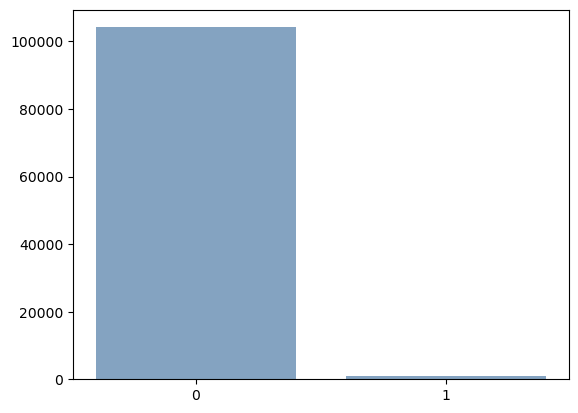

  0%|          | 0/105320 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/6702 [00:00<?, ?it/s]

  0%|          | 0/6702 [00:00<?, ?it/s]

DISTRIBUTION AFTER UNDERSAMPLING


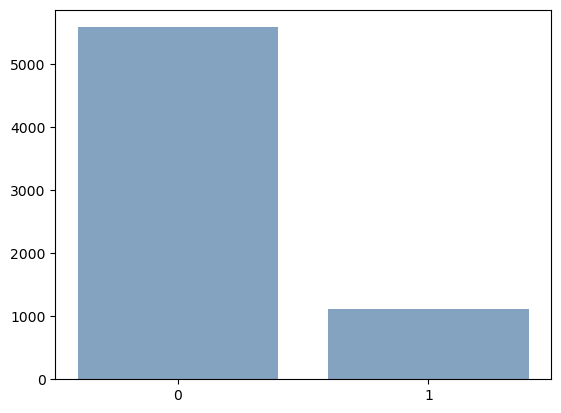

Dataset After Reampling
positives = 1117, negatives: 5585   ration: 1/5


In [ ]:
impression = data.createNewData(window = __WINDOW__)
OneHotEncoderNewEmbeddings = list(np.load(file='./complete.npy')) #LOAD DATA SAVED FROM EMBEDDINGS
OneHotEncoderNewEmbeddingsWindow = getDataWindow(OneHotEncoderNewEmbeddings, window = __WINDOW__ )


''' 
insert the combination BERT into the original dataframe
'''
impression["BERT_News_Embeddings"] = OneHotEncoderNewEmbeddingsWindow
impression_train, impression_validate, impression_test = splitData(impression)

del OneHotEncoderNewEmbeddings, data, impression, OneHotEncoderNewEmbeddingsWindow
gc.collect()

''' UNDERSAPING DATA '''

print(f'Original Dataset')
zero, ones = verifyDataset(impression_train, returnEnable = True)
# ratioPercentage = 1/100
impression_train = undersamplingData(impression_train, window = __WINDOW__ ,ratio = 1 / 5)
print(f'Dataset After Reampling')
verifyDataset(impression_train)

### CREATING DATA FOR THE MODEL 

In [ ]:
train = dataChecktoNormalize(impression_train)
validate = dataChecktoNormalize(impression_validate)
test = dataChecktoNormalize(impression_test)

train_X, train_XBERT, train_y = splitXY(train)
validate_X, validate_XBERT, validate_y = splitXY(validate)
test_X, test_XBERT, test_y = splitXY(test)
       
trainData = DatasetClass(train_X, train_XBERT, train_y)
validateData = DatasetClass(validate_X, validate_XBERT, validate_y)
testData = DatasetClass(test_X, test_XBERT, test_y)

  0%|          | 0/6702 [00:00<?, ?it/s]

  0%|          | 0/34362 [00:00<?, ?it/s]

  0%|          | 0/10341 [00:00<?, ?it/s]

  0%|          | 0/6702 [00:00<?, ?it/s]

  0%|          | 0/34362 [00:00<?, ?it/s]

  0%|          | 0/10341 [00:00<?, ?it/s]

#### SAVE DATA FOR MODEL

In [2]:
train = pd.read_json('./beforeTrainWindow5/train.json')
validate = pd.read_json('./beforeTrainWindow5/validate.json')
test = pd.read_json('./beforeTrainWindow5/test.json')

validate.drop('Date', axis = 1, inplace= True)
test.drop('Date', axis = 1, inplace= True)


In [3]:
train_X, train_XBERT, train_y = np.load('./beforeTrainWindow5/train_X.npy'), np.load('./beforeTrainWindow5/train_XBERT.npy'), np.load('./beforeTrainWindow5/train_y.npy')
validate_X, validate_XBERT, validate_y = np.load('./beforeTrainWindow5/validate_X.npy'), np.load('./beforeTrainWindow5/validate_XBERT.npy'), np.load('./beforeTrainWindow5/validate_y.npy')
test_X, test_XBERT, test_y = np.load('./beforeTrainWindow5/test_X.npy'), np.load('./beforeTrainWindow5/test_XBERT.npy'), np.load('./beforeTrainWindow5/test_y.npy')

In [4]:
trainData = DatasetClass(train_X, train_XBERT, train_y)
validateData = DatasetClass(validate_X, validate_XBERT, validate_y)
testData = DatasetClass(test_X, test_XBERT, test_y)

In [ ]:
# train.to_json('./beforeTrainWindow5/train.json')
# validate.reset_index(inplace=True)
# validate.to_json('./beforeTrainWindow5/validate.json')
# test.reset_index(inplace=True)
# test.to_json('./beforeTrainWindow5/test.json')

In [ ]:
# np.save('./beforeTrainWindow5/train_X.npy', train_X)
# np.save('./beforeTrainWindow5/train_XBERT.npy', train_XBERT)
# np.save('./beforeTrainWindow5/train_y.npy', train_y)

# np.save('./beforeTrainWindow5/validate_X.npy', validate_X)
# np.save('./beforeTrainWindow5/validate_XBERT.npy', validate_XBERT)
# np.save('./beforeTrainWindow5/validate_y.npy', validate_y)

# np.save('./beforeTrainWindow5/test_X.npy', test_X)
# np.save('./beforeTrainWindow5/test_XBERT.npy', test_XBERT)
# np.save('./beforeTrainWindow5/test_y.npy', test_y)

### BONUS TEST

  0%|          | 0/100 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 99 | Step: 9 / 14 | Training loss: 1.61482 |  Training PRC: 0.14189
Validation Stage ==> Epoch: 0 / 99 | Validation loss: 0.21441 |  Validation PRC: 0.00817
Training Stage ==> Epoch: 1 / 99 | Step: 9 / 14 | Training loss: 1.70718 |  Training PRC: 0.23175
Validation Stage ==> Epoch: 1 / 99 | Validation loss: 0.55708 |  Validation PRC: 0.00789
Training Stage ==> Epoch: 2 / 99 | Step: 9 / 14 | Training loss: 1.48968 |  Training PRC: 0.22464
Validation Stage ==> Epoch: 2 / 99 | Validation loss: 0.70440 |  Validation PRC: 0.00852
Training Stage ==> Epoch: 3 / 99 | Step: 9 / 14 | Training loss: 1.21611 |  Training PRC: 0.22165
Validation Stage ==> Epoch: 3 / 99 | Validation loss: 0.63334 |  Validation PRC: 0.00950
Training Stage ==> Epoch: 4 / 99 | Step: 9 / 14 | Training loss: 1.15718 |  Training PRC: 0.24201
Validation Stage ==> Epoch: 4 / 99 | Validation loss: 0.85895 |  Validation PRC: 0.00932
Training Stage ==> Epoch: 5 / 99 | Step: 9 / 14 | Training loss: 

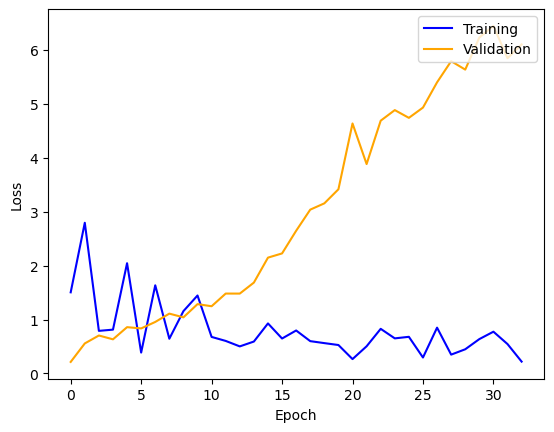

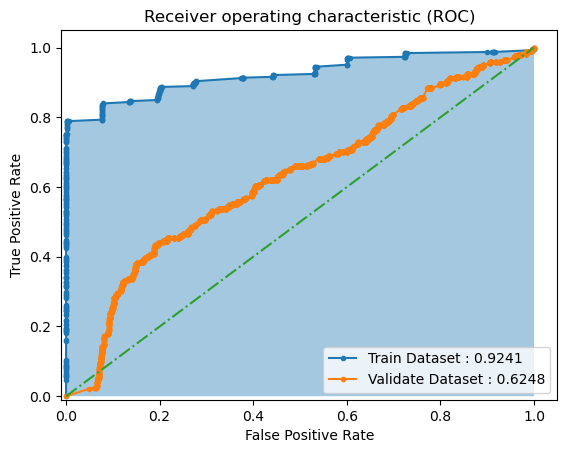

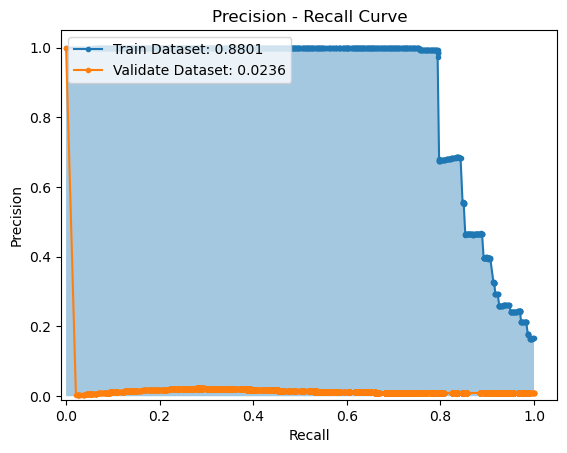

Best Threshold f1 0.999
_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 8.50992488861084 |  PRC: 0.22390455845124452 | precision: 0.03933054393305439 |recall: 0.4017094017094017 | f1_score: 0.07164634146341463 | AUROC: 0.6447122908390513
Confusion Matrix
18152 2296 140 94
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     20448
         1.0       0.04      0.40      0.07       234

    accuracy                           0.88     20682
   macro avg       0.52      0.64      0.50     20682
weighted avg       0.98      0.88      0.93     20682



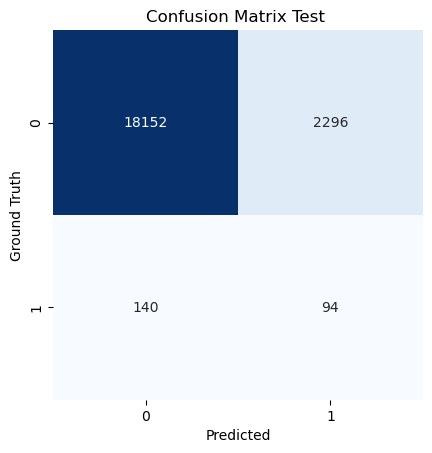

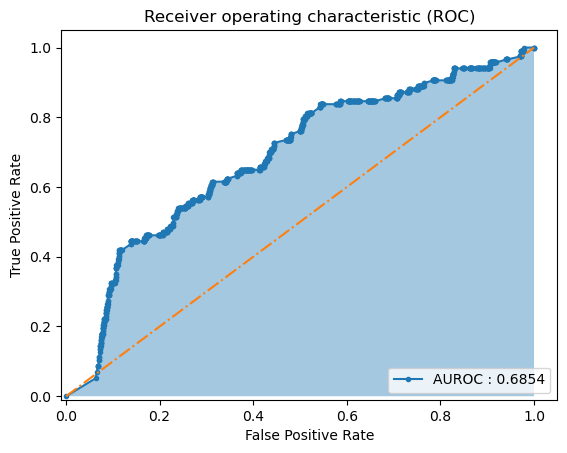

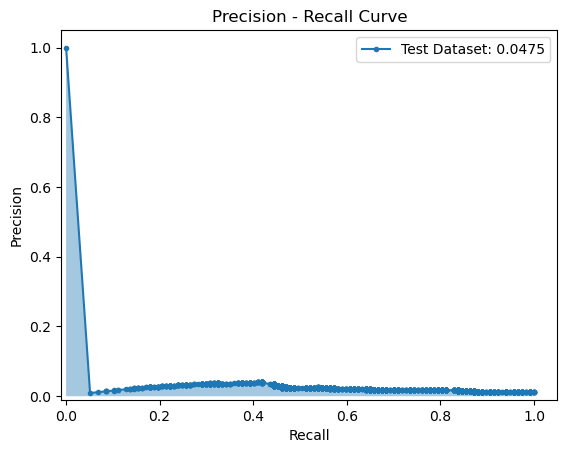

In [23]:
torch.cuda.empty_cache()

features_Clicks = train_X.shape[2]
features_News = train_XBERT.shape[2]

__N_EPOCHS_TR__ = 100
__N_BATCHS_TR__ = 512
__LEARNING_RATE_TR__ = 3.3e-6
__TYPE_METRIC_TR__ = 'PRC' #"AUROC" 'recall' 'f1'
__N_HEADS1__ = 1
__N_HEADS2__ = 3

__EARLY_STOP_TR__ = True
__PATIENTE_TR__ = 2

__SHOW_PROCESS_TR__ = True
__PROCESS_FACTOR_TR__ = 10

if 'Bonus' in locals():
    del Bonus
    gc.collect()

Bonus = AIModel(
    trainData, 
    validateData, 
    testData, 
    features_Clicks,
    features_News,
    epoch = __N_EPOCHS_TR__, 
    batch_size = __N_BATCHS_TR__, 
    learning_rate= __LEARNING_RATE_TR__, 
    typeMetric = __TYPE_METRIC_TR__,
    earlyStopFlag = __EARLY_STOP_TR__,
    nhead1 = __N_HEADS1__,
    nhead2 = __N_HEADS2__,
    device= __TEST_DEVICE__
    )

Bonus.trainModel(
    show_process = __SHOW_PROCESS_TR__, 
    process_factor = __PROCESS_FACTOR_TR__, 
    patiente = __PATIENTE_TR__
    )

Bonus.plot_Acc_loss()
Bonus.ROC_curves()
Bonus.PRC_curves()

th, _ = Bonus.testModel_GetThreshold(Bonus.test, typeData = 'f1')
print('Best Threshold f1', th)

torch.cuda.empty_cache() 

print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')
Bonus.testModel(Bonus.test, showMetrics = True, threshold = th, threshold_flag=True)
Bonus.ConfusionMatrixPlotIndividual(Bonus.test, threshold = th, threshold_flag=True)
Bonus.ROC_plot(Bonus.test, thresholdCompare = th)
Bonus.PRC_plot(Bonus.test, thresholdCompare = th)


torch.cuda.empty_cache() 




_____________________________________________________________________________________
                                  TESTING F1                                          
_____________________________________________________________________________________
Model Metrics: | Loss: 8.50992488861084 |  PRC: 0.324277417576108 | precision: 0.020368303571428572 |recall: 0.6239316239316239 | f1_score: 0.03944879762226425 | AUROC: 0.640261977850006
Confusion Matrix
13426 7022 88 146
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.66      0.79     20448
         1.0       0.02      0.62      0.04       234

    accuracy                           0.66     20682
   macro avg       0.51      0.64      0.42     20682
weighted avg       0.98      0.66      0.78     20682



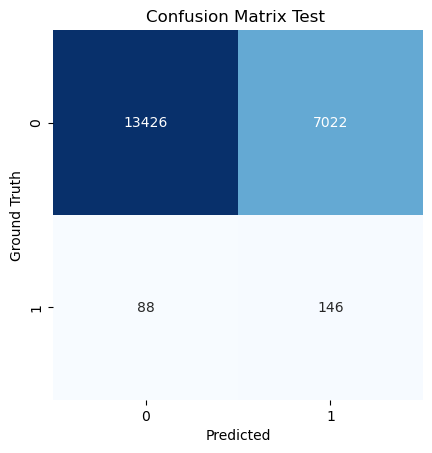

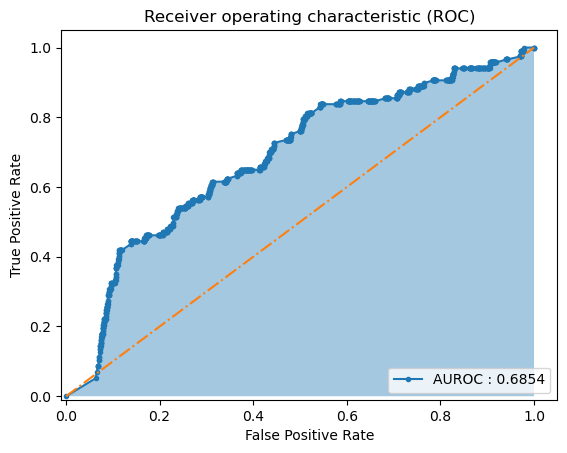

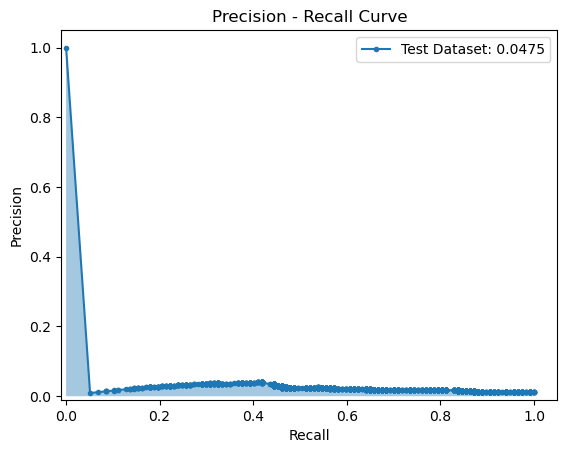

In [30]:
th1 = 0.958
print(f'_____________________________________________________________________________________')
print('                                  TESTING F1                                          ')
print(f'_____________________________________________________________________________________')

Bonus.testModel(Bonus.test, showMetrics = True, threshold = th1, threshold_flag=True)
Bonus.ConfusionMatrixPlotIndividual(Bonus.test, threshold = th1, threshold_flag=True)
Bonus.ROC_plot(Bonus.test, thresholdCompare = th1)
Bonus.PRC_plot(Bonus.test, thresholdCompare = th1)


torch.cuda.empty_cache() 

